## **DEEP LEARNING PROJECT WORK**
The systems have to decide whether or not a given headline contains or describes sarcastic expressions or behaviors.

### Dataset Description
https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection/data

**Context**<br>
Past studies in Sarcasm Detection mostly make use of Twitter datasets collected using hashtag based supervision but such datasets are noisy in terms of labels and language. Furthermore, many tweets are replies to other tweets and detecting sarcasm in these requires the availability of contextual tweets.

To overcome the limitations related to noise in Twitter datasets, this News Headlines dataset for Sarcasm Detection is collected from two news website. TheOnion aims at producing sarcastic versions of current events and we collected all the headlines from News in Brief and News in Photos categories (which are sarcastic). We collect real (and non-sarcastic) news headlines from HuffPost.

This new dataset has following advantages over the existing Twitter datasets:

Since news headlines are written by professionals in a formal manner, there are no spelling mistakes and informal usage. This reduces the sparsity and also increases the chance of finding pre-trained embeddings.

Furthermore, since the sole purpose of TheOnion is to publish sarcastic news, we get high-quality labels with much less noise as compared to Twitter datasets.

Unlike tweets which are replies to other tweets, the news headlines we obtained are self-contained. This would help us in teasing apart the real sarcastic elements.<br><br>

**Content**<br>
Each record consists of three attributes:

is_sarcastic: 1 if the record is sarcastic otherwise 0

headline: the headline of the news article

article_link: link to the original news article. Useful in collecting supplementary data



USEFUL LIBRARIES


In [ ]:
import os
import requests
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import zipfile
import numpy as np
from tqdm import tqdm
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, precision_recall_curve, PrecisionRecallDisplay, classification_report
from IPython.display import display, HTML
from wordcloud import WordCloud
from collections import Counter
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import random
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
warnings.filterwarnings("ignore", category=FutureWarning)

# Import the Dataset and preprocessing

In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')
!cp -r /content/drive/MyDrive/deep_learning/project_work/archive.zip ./
!unzip archive.zip
df_original = pd.read_json("Sarcasm_Headlines_Dataset.json", lines=True)

Mounted at /content/drive
Archive:  archive.zip
  inflating: Sarcasm_Headlines_Dataset.json  
  inflating: Sarcasm_Headlines_Dataset_v2.json  


In [ ]:
df = df_original.copy()

In [ ]:
df.head()

article_link  \
0  https://www.huffingtonpost.com/entry/versace-b...   
1  https://www.huffingtonpost.com/entry/roseanne-...   
2  https://local.theonion.com/mom-starting-to-fea...   
3  https://politics.theonion.com/boehner-just-wan...   
4  https://www.huffingtonpost.com/entry/jk-rowlin...   

                                            headline  is_sarcastic  
0  former versace store clerk sues over secret 'b...             0  
1  the 'roseanne' revival catches up to our thorn...             0  
2  mom starting to fear son's web series closest ...             1  
3  boehner just wants wife to listen, not come up...             1  
4  j.k. rowling wishes snape happy birthday in th...             0

In [ ]:
print(f'shape of the dataset: {df.shape}')

shape of the dataset: (26709, 3)


In [ ]:
def check_dataset(df):
    initial_rows = df.shape[0]
    print(f"Starting number of samples: {initial_rows}")
    print("\nNumber of null values:")
    print(df.isnull().sum())
    df = df.dropna()
    df = df.drop_duplicates()
    if 'is_sarcastic' in df.columns:
        df = df.rename(columns={'is_sarcastic': 'label'})
        print("\nColumn 'is_sarcastic' renamed to 'label'.")
    else:
        print("\nColumn 'is_sarcastic' not found. No renaming applied.")
    final_rows = df.shape[0]
    print(f"\nCurrent number of samples: {final_rows}")
    return df

df = check_dataset(df)

Starting number of samples: 26709

Number of null values:
article_link    0
headline        0
is_sarcastic    0
dtype: int64

Column 'is_sarcastic' renamed to 'label'.

Current number of samples: 26708


Here, I defined the training, validation, and test sets. To ensure that the training is as balanced as possible in learning the two classes, I decided to create a training set with an equal number of labels for both classes.

In [ ]:
from sklearn.model_selection import train_test_split

def split_dataset(df, train_ratio=0.70, val_ratio=0.20, test_ratio=0.10, random_state=42):
    if not abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6:
        raise ValueError("sum over train_ratio, val_ratio and test_ratio must be equal to 1.0")

    train_val_set, test_set = train_test_split(df, test_size=test_ratio, random_state=random_state)

    val_ratio_adjusted = val_ratio / (train_ratio + val_ratio)
    train_set, val_set = train_test_split(train_val_set, test_size=val_ratio_adjusted, random_state=random_state)

    # balance for the training labels
    label_0 = train_set[train_set['label'] == 0]
    label_1 = train_set[train_set['label'] == 1]

    min_samples = min(len(label_0), len(label_1))
    label_0_balanced = label_0.sample(n=min_samples, random_state=random_state)
    label_1_balanced = label_1.sample(n=min_samples, random_state=random_state)
    train_set_balanced = pd.concat([label_0_balanced, label_1_balanced]).sample(frac=1, random_state=random_state)

    return train_set_balanced, val_set, test_set

train_set, val_set, test_set = split_dataset(df)
print(f"Numero di sample nel training set: {len(train_set)}")
print(f"Numero di sample nel validation set: {len(val_set)}")
print(f"Numero di sample nel test set: {len(test_set)}")

Numero di sample nel training set: 16414
Numero di sample nel validation set: 5342
Numero di sample nel test set: 2671


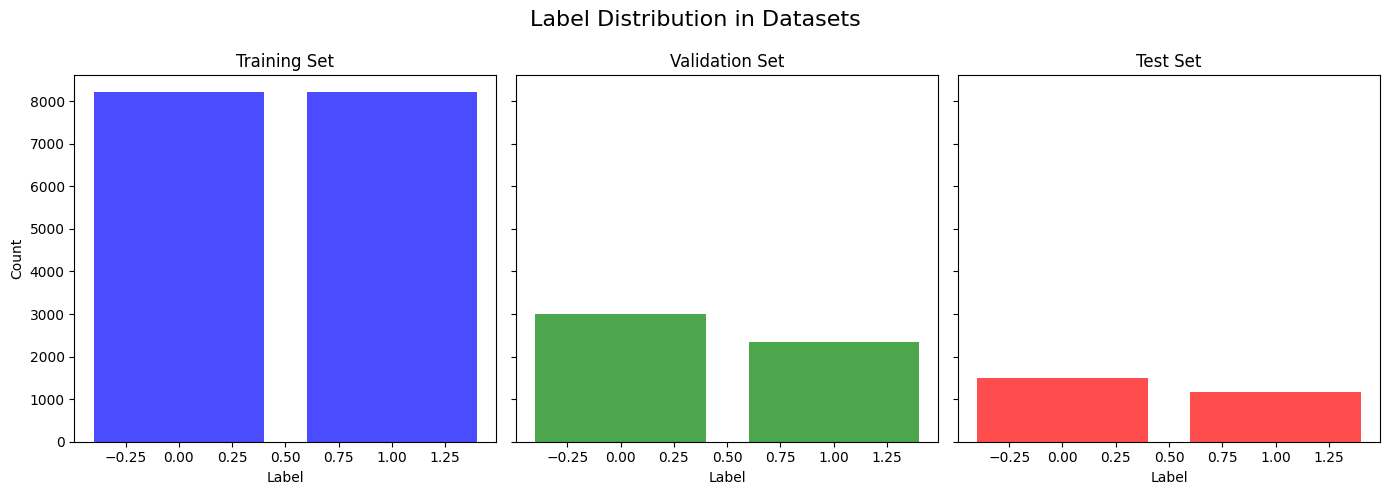

In [ ]:
def plot_label_distribution(train_set, val_set, test_set, label_column):
    train_counts = train_set[label_column].value_counts()
    val_counts = val_set[label_column].value_counts()
    test_counts = test_set[label_column].value_counts()

    fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharey=True)
    fig.suptitle("Label Distribution in Datasets", fontsize=16)

    axes[0].bar(train_counts.index, train_counts.values, color='blue', alpha=0.7)
    axes[0].set_title("Training Set")
    axes[0].set_xlabel("Label")
    axes[0].set_ylabel("Count")

    axes[1].bar(val_counts.index, val_counts.values, color='green', alpha=0.7)
    axes[1].set_title("Validation Set")
    axes[1].set_xlabel("Label")

    axes[2].bar(test_counts.index, test_counts.values, color='red', alpha=0.7)
    axes[2].set_title("Test Set")
    axes[2].set_xlabel("Label")

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

plot_label_distribution(train_set, val_set, test_set, label_column="label")

In [ ]:
original_train_df = train_set.copy()
original_validation_df = val_set.copy()
original_test_df = test_set.copy()
(original_train_df).head()

article_link  \
13730  https://www.theonion.com/ticketed-motorist-poi...   
9054   https://www.huffingtonpost.com/entry/create-an...   
2326   https://entertainment.theonion.com/christian-r...   
14517  https://www.huffingtonpost.comhttps://www.thed...   
26591  https://www.huffingtonpost.com/entry/hope-solo...   

                                                headline  label  
13730  ticketed motorist pointing finger just the gre...      1  
9054     create an environment for your ultimate success      0  
2326                           christian rock uninspired      1  
14517    cat so scared in shelter won't even look at you      0  
26591  hope solo shows off zika defense armor for rio...      0

I removed the **article_link** column

In [ ]:
original_train_df = original_train_df.drop(columns=['article_link'])
original_validation_df = original_validation_df.drop(columns=['article_link'])
original_test_df = original_test_df.drop(columns=['article_link'])
original_train_df.head()

headline  label
13730  ticketed motorist pointing finger just the gre...      1
9054     create an environment for your ultimate success      0
2326                           christian rock uninspired      1
14517    cat so scared in shelter won't even look at you      0
26591  hope solo shows off zika defense armor for rio...      0

In [ ]:
train_df = original_train_df.copy()
validation_df = original_validation_df.copy()
test_df = original_test_df.copy()

A quick look at the bigrams reveals a distinction between sarcastic and non-sarcastic headlines. In sarcastic headlines, stereotypical expressions like *area man*, *study finds*, and *year old* emerge, typical of an ironic style that mimics journalistic language in an exaggerated or parodic way. In non-sarcastic headlines, on the other hand, more informative bigrams related to current events prevail, such as *donald trump*, *hillary clinton*, and *north korea*, indicating a focus on politics and real news.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Random Samples:

idx 13332: paul ryan says he and steve bannon are 'different kinds of conservatives' | Label: Not Sarcastic
idx 7288: 50-year-old prince licks aarp representative's face | Label: Sarcastic
idx 12520: the tennis racket | Label: Not Sarcastic
idx 4073: man unknowingly purchases lifetime supply of condoms | Label: Sarcastic
idx 15233: entire office clamoring to be introduced to coworker's parents | Label: Sarcastic
idx 3990: giant murals disappear with the tides because nothing lasts forever | Label: Not Sarcastic
idx 8936: violence hits nigeria's oil-rich delta region | Label: Not Sarcastic
idx 8434: bouncer moved to tears by tale of friends already in club | Label: Sarcastic
idx 3155: peanut exec faces life sentence for shipping tainted peanut butter | Label: Not Sarcastic
idx 11668: outline of inhaler clearly visible in comic-con attendee's lycra bodysuit | Label: Sarcastic




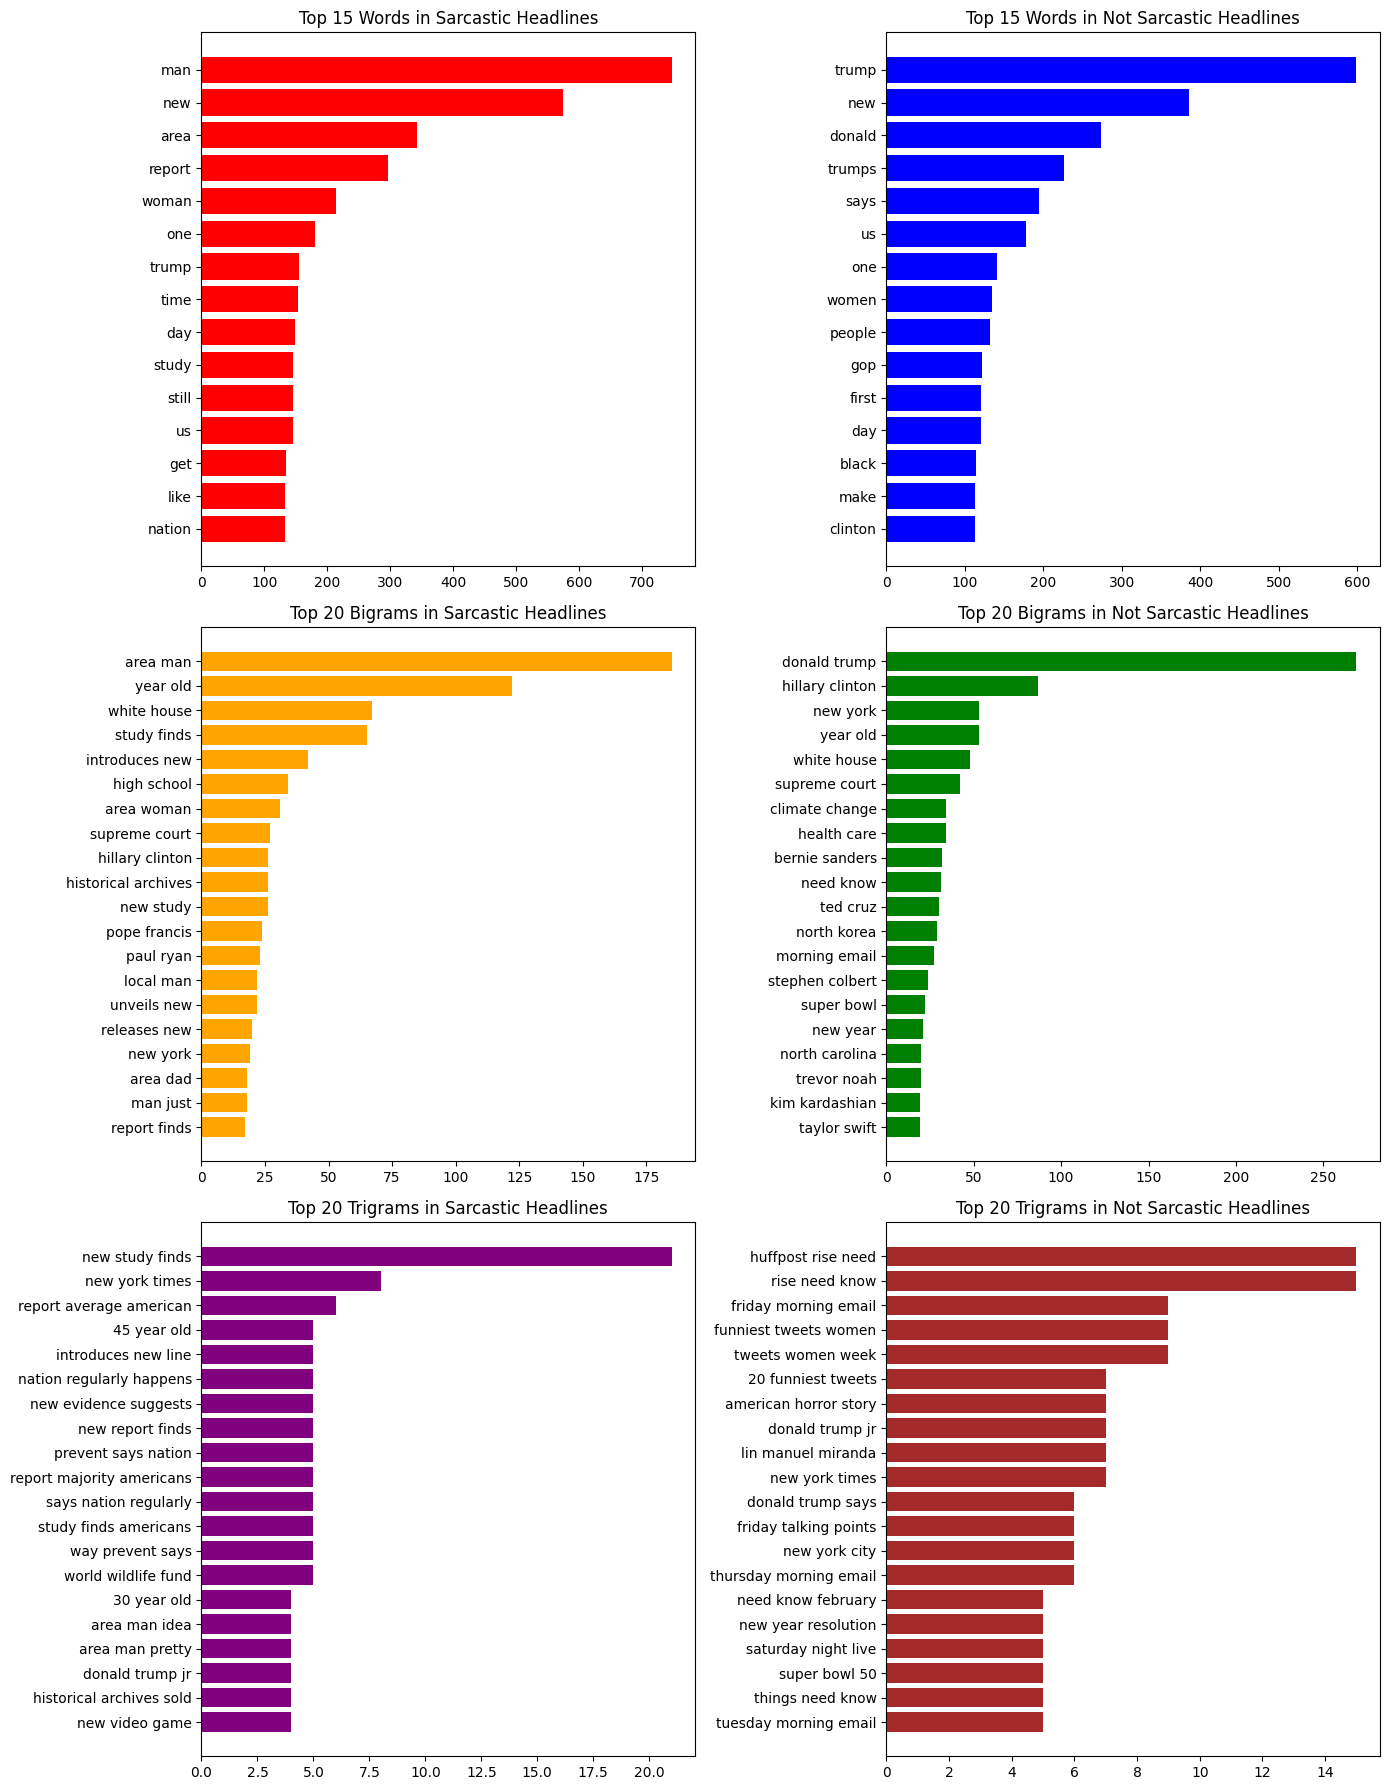

In [ ]:
nltk.download('stopwords')
def display_random_samples_and_word_histogram(train_df):
    stop_words = set(stopwords.words('english'))
    random_indices = random.sample(range(len(train_df)), 10)
    print("Random Samples:\n")
    for idx in random_indices:
        headline = train_df['headline'].iloc[idx]
        label = 'Sarcastic' if train_df['label'].iloc[idx] == 1 else 'Not Sarcastic'
        print(f'idx {idx}: {headline} | Label: {label}')
    print('\n')

    sarcastic_headlines = train_df[train_df['label'] == 1]['headline']
    not_sarcastic_headlines = train_df[train_df['label'] == 0]['headline']

    def tokenize_and_clean(text):
        text = re.sub(r'[^\w\s]', '', text.lower())
        return [word for word in text.split() if word not in stop_words]  # Remove stopwords

    sarcastic_words = Counter(word for headline in sarcastic_headlines for word in tokenize_and_clean(headline))
    not_sarcastic_words = Counter(word for headline in not_sarcastic_headlines for word in tokenize_and_clean(headline))

    top_sarcastic = sarcastic_words.most_common(15)
    top_not_sarcastic = not_sarcastic_words.most_common(15)

    fig, axes = plt.subplots(3, 2, figsize=(14, 18))

    sarcastic_words, sarcastic_counts = zip(*top_sarcastic)
    axes[0, 0].barh(sarcastic_words, sarcastic_counts, color='red')
    axes[0, 0].set_title('Top 15 Words in Sarcastic Headlines')
    axes[0, 0].invert_yaxis()

    not_sarcastic_words, not_sarcastic_counts = zip(*top_not_sarcastic)
    axes[0, 1].barh(not_sarcastic_words, not_sarcastic_counts, color='blue')
    axes[0, 1].set_title('Top 15 Words in Not Sarcastic Headlines')
    axes[0, 1].invert_yaxis()

    def get_top_ngrams(corpus, n=3, top_k=20):
        vectorizer = CountVectorizer(ngram_range=(n, n), stop_words='english')
        X = vectorizer.fit_transform(corpus)
        ngram_counts = Counter(dict(zip(vectorizer.get_feature_names_out(), X.sum(axis=0).A1)))
        return ngram_counts.most_common(top_k)

    top_sarcastic_trigrams = get_top_ngrams(sarcastic_headlines, n=2, top_k=20)
    top_not_sarcastic_trigrams = get_top_ngrams(not_sarcastic_headlines, n=2, top_k=20)

    sarcastic_trigrams, sarcastic_trigram_counts = zip(*top_sarcastic_trigrams)
    axes[1, 0].barh(sarcastic_trigrams, sarcastic_trigram_counts, color='orange')
    axes[1, 0].set_title('Top 20 Bigrams in Sarcastic Headlines')
    axes[1, 0].invert_yaxis()

    not_sarcastic_trigrams, not_sarcastic_trigram_counts = zip(*top_not_sarcastic_trigrams)
    axes[1, 1].barh(not_sarcastic_trigrams, not_sarcastic_trigram_counts, color='green')
    axes[1, 1].set_title('Top 20 Bigrams in Not Sarcastic Headlines')
    axes[1, 1].invert_yaxis()

    top_sarcastic_quadgrams = get_top_ngrams(sarcastic_headlines, n=3, top_k=20)
    top_not_sarcastic_quadgrams = get_top_ngrams(not_sarcastic_headlines, n=3, top_k=20)

    sarcastic_quadgrams, sarcastic_quadgram_counts = zip(*top_sarcastic_quadgrams)
    axes[2, 0].barh(sarcastic_quadgrams, sarcastic_quadgram_counts, color='purple')
    axes[2, 0].set_title('Top 20 Trigrams in Sarcastic Headlines')
    axes[2, 0].invert_yaxis()

    not_sarcastic_quadgrams, not_sarcastic_quadgram_counts = zip(*top_not_sarcastic_quadgrams)
    axes[2, 1].barh(not_sarcastic_quadgrams, not_sarcastic_quadgram_counts, color='brown')
    axes[2, 1].set_title('Top 20 Trigrams in Not Sarcastic Headlines')
    axes[2, 1].invert_yaxis()

    plt.tight_layout()
    plt.show()

display_random_samples_and_word_histogram(train_df)

#Data Cleaning
In the context of headlines, we could have noisy and informal data that includes unnecessary elements.


- **Remove special characters and symbols**.
- **Remove specific quote characters** (e.g., curly quotes).
- **Perform lemmatization** to reduce words to their base form

In [ ]:
# Create the lemmatizer
lemmatizer = WordNetLemmatizer()

def clean_headline_rnn(headline):
    # Remove special characters and symbols
    headline = re.sub(r'[^a-zA-Z0-9\s]', '', headline)
    # Remove specific quote characters (curly quotes, etc.)
    headline = headline.replace('“', '').replace('”', '').replace('‘', '').replace('’', '')
    # Convert to lowercase
    headline = headline.lower()
    # Tokenizer
    words = word_tokenize(headline)
    # Lemmatize
    words = [lemmatizer.lemmatize(word) for word in words]
    # Rejoin words into a cleaned-up headline
    cleaned_headline = ' '.join(words)
    return cleaned_headline

In [ ]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

# Apply the cleaning function to the 'headline' column
train_df['headline'] = train_df['headline'].apply(clean_headline_rnn)
validation_df['headline'] = validation_df['headline'].apply(clean_headline_rnn)
test_df['headline'] = test_df['headline'].apply(clean_headline_rnn)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## Text Encoding
I decided to use static dense embeddings. I chose to use GloVe embeddings to encode the vocabulary for the RNN and LSTM models. I started by using embeddings with a size of 100 dimensions.




In [ ]:
def download_glove_embeddings(glove_url, save_path='glove.zip', extract_path='glove'):
    if not os.path.exists(extract_path):  # Only download if not already downloaded
        print("Downloading GloVe embeddings...")
        response = requests.get(glove_url, stream=True)
        total_size = int(response.headers.get('content-length', 0))

        with open(save_path, 'wb') as f, tqdm(
            desc="Downloading",
            total=total_size,
            unit='B',
            unit_scale=True,
            unit_divisor=1024,
        ) as bar:
            for data in response.iter_content(chunk_size=1024):
                f.write(data)
                bar.update(len(data))

        print("Extracting GloVe embeddings...")
        with zipfile.ZipFile(save_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)

        os.remove(save_path)
        print("Download and extraction complete.")
    else:
        print("GloVe embeddings already downloaded.")


# Load the GloVe embeddings from the extracted file
def load_glove_embeddings(filepath, embedding_dim=100):
    embeddings = {}
    with open(filepath, 'r', encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

glove_url = "http://nlp.stanford.edu/data/glove.6B.zip"  # 6B is the 400K word vocab, various embedding dim
download_path = 'glove.6B.zip'
extract_path = 'glove'

download_glove_embeddings(glove_url, download_path, extract_path)

# Specify the embedding dimension and file, choose dim from 50,100,200,300
embedding_dim = 100
glove_filepath = os.path.join(extract_path, f'glove.6B.{embedding_dim}d.txt')

# Load embeddings
glove_embeddings = load_glove_embeddings(glove_filepath, embedding_dim)
print("Loaded GloVe embeddings with dimension:", embedding_dim)

Downloading: 100%|██████████| 822M/822M [02:39<00:00, 5.41MB/s]


Extracting GloVe embeddings...
Download and extraction complete.
Loaded GloVe embeddings with dimension: 100


## Padding

In [ ]:
def pad_headlines(df, column_name, pad_token="<PAD>"):
    # Calculate the maximum headline length
    max_len = max(len(headline.split()) for headline in df[column_name])
    print(f'max len: ={max_len}')
    # Apply padding or truncation
    return df[column_name].apply(
        lambda x: x.split()[:max_len] + [pad_token] * max(0, max_len - len(x.split()))
    )

In [ ]:
train_df['padded_headline'] = pad_headlines(train_df, 'headline')
validation_df['padded_headline'] = pad_headlines(validation_df, 'headline')
test_df['padded_headline'] = pad_headlines(test_df, 'headline')
print('first padded headline:')
print(train_df['padded_headline'][0])
train_df.head()

max len: =39
max len: =24
max len: =22
first padded headline:
['former', 'versace', 'store', 'clerk', 'sue', 'over', 'secret', 'black', 'code', 'for', 'minority', 'shopper', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


headline  label  \
13730  ticketed motorist pointing finger just the gre...      1   
9054     create an environment for your ultimate success      0   
2326                           christian rock uninspired      1   
14517     cat so scared in shelter wont even look at you      0   
26591  hope solo show off zika defense armor for rio ...      0   

                                         padded_headline  
13730  [ticketed, motorist, pointing, finger, just, t...  
9054   [create, an, environment, for, your, ultimate,...  
2326   [christian, rock, uninspired, <PAD>, <PAD>, <P...  
14517  [cat, so, scared, in, shelter, wont, even, loo...  
26591  [hope, solo, show, off, zika, defense, armor, ...

### OOV handling
   * All the tokens in the **training** set that are not in GloVe were be added to the vocabulary.
   * For the remaining tokens (OOV in the validation and test sets), I assigned them the [UNK] token.



To handle the words that are not in Glove, besides that the PAD token, I used a "static character-level embeddings" which computes the mean of the characters of the tokens. For the PAD tokens I decided to assign an embedding of zeros.

In [ ]:
# Compute the average of each dimension
def compute_average_embedding(embeddings):
    all_vectors = np.array(list(embeddings.values()))
    average_vector = np.mean(all_vectors, axis=0)
    return average_vector

# Compute the average vector
average_vector = compute_average_embedding(glove_embeddings)
print("\nAverage of each dimension across all embeddings:")
print(average_vector)
print(np.max(average_vector))
print(np.min(average_vector))


Average of each dimension across all embeddings:
[ 0.05209883 -0.09711445 -0.1380765   0.11075345 -0.02722748 -0.00326409
  0.03176443 -0.05076874  0.15321693 -0.02367382 -0.0078552   0.08436131
 -0.08042031 -0.08836847 -0.01713637  0.07352565 -0.16472325  0.05473585
  0.15367231 -0.05284015 -0.16474274 -0.00894895 -0.13604094 -0.03889371
 -0.09204532  0.02874651  0.02445944  0.19419461 -0.03297978  0.00509352
  0.0146906  -0.1554301   0.03542742 -0.02936257  0.01372886 -0.0606757
  0.02025392 -0.14560148  0.05823914  0.01729455  0.16282158  0.18634756
 -0.06337869  0.1306742  -0.11122588  0.0272168   0.03868013  0.15675613
  0.01344932  0.1942456  -0.01218801  0.03659216 -0.08235365 -0.24420363
  0.07523726  0.46423653  0.06318451  0.0508127  -0.38147202 -0.20739552
  0.03489431 -0.18234783  0.09021272 -0.02504168 -0.22256528  0.03382994
 -0.13379364 -0.14375682 -0.11264054 -0.03744001  0.06188852  0.09650661
  0.08384212  0.1964642  -0.07446123  0.00921882  0.03034359 -0.02482695
  

In [ ]:
def build_vocab_and_embeddings_char(data, embeddings_index, embedding_dim):
    vocab = {}
    word_embeddings = []

    def get_word_embedding_from_chars(token):
        char_embeddings = []
        for char in token:
            if char in embeddings_index:
                char_embeddings.append(embeddings_index[char])
            else:
                # Assign a random embedding for unknown characters. The value for each dimension is bounded among the max and min value of the mean over all the glove embedding dimensions
                char_embeddings.append(np.random.uniform(np.min(average_vector), np.max(average_vector), embedding_dim))
        # Compute the average of character embeddings to represent the word
        return np.mean(char_embeddings, axis=0)

    # Iterate over all padded headlines in the dataset
    for headline in data['padded_headline']:
        for token in headline:
            # Check if the token is already in the vocabulary
            if token not in vocab:
              if token in embeddings_index:
                  # If the token exists in the pre-trained embeddings, use its embedding
                  vocab[token] = len(vocab)
                  word_embeddings.append(embeddings_index[token])
              elif token != "<PAD>":
                  # Compute the word embedding using character-level embeddings
                  word_embedding = get_word_embedding_from_chars(token)
                  vocab[token] = len(vocab)
                  word_embeddings.append(word_embedding)
              else:
                  vocab[token] = len(vocab)
                  #word_embeddings.append(np.random.uniform(-0.1, 0.1, embedding_dim))  # Random embedding, this is my previous choice
                  word_embeddings.append(np.random.uniform(0, 0, embedding_dim))

    return vocab, np.array(word_embeddings)

vocab, word_embeddings = build_vocab_and_embeddings_char(train_df, glove_embeddings, embedding_dim)

In [ ]:
print(len(vocab))

19851


To handle OOV words here I added the token '[UNK]' to the vocabulary and as its embedding I took the mean of all pre-trained embeddings in the current word embedding list.

In [ ]:
# Add [UNK] token for unknown words to the vocabulary
unk_token = '[UNK]'
vocab[unk_token] = len(vocab)  # Assign a unique index to the '[UNK]' token in the vocabulary

# I decided to use the mean of all pre-trained embeddings in the current word_embeddings list to define the UNK embedding
unk_embedding = np.mean(word_embeddings, axis=0)

# Add the '[UNK]' embedding to the word_embeddings matrix
word_embeddings = np.vstack([word_embeddings, unk_embedding])

In [ ]:
# Function to apply embeddings to the padded headlines in a DataFrame
def embed_headline(df, vocab, word_embeddings):
    data = df.copy()
    new_headline = []  # List to store the embedded headlines

    for headline in data['padded_headline']:
        embedded_headline = []

        for token in headline:
            if token not in vocab:
                # If the token is not in the vocabulary, treat it as [UNK]
                embedded_headline.append(word_embeddings[vocab['[UNK]']])
            else:
                # Otherwise, use the corresponding embedding for the token
                embedded_headline.append(word_embeddings[vocab[token]])

        new_headline.append(embedded_headline)

    data['embed_headline'] = new_headline
    return data

In [ ]:
train_df_embedded = embed_headline(train_df, vocab, word_embeddings)
validation_df_embedded = embed_headline(validation_df, vocab, word_embeddings)
test_df_embedded = embed_headline(test_df, vocab, word_embeddings)
train_df_embedded.head()

headline  label  \
13730  ticketed motorist pointing finger just the gre...      1   
9054     create an environment for your ultimate success      0   
2326                           christian rock uninspired      1   
14517     cat so scared in shelter wont even look at you      0   
26591  hope solo show off zika defense armor for rio ...      0   

                                         padded_headline  \
13730  [ticketed, motorist, pointing, finger, just, t...   
9054   [create, an, environment, for, your, ultimate,...   
2326   [christian, rock, uninspired, <PAD>, <PAD>, <P...   
14517  [cat, so, scared, in, shelter, wont, even, loo...   
26591  [hope, solo, show, off, zika, defense, armor, ...   

                                          embed_headline  
13730  [[0.11706999689340591, -0.5184500217437744, -0...  
9054   [[-0.2638300061225891, 0.263729989528656, -0.3...  
2326   [[0.23529000580310822, 0.9434499740600586, -0....  
14517  [[0.230880007147789, 0.28282999992370605, 0.63...  
26591  [[0.034876998513936996, 0.4607900083065033, 0....

How many OOV tokens in the validation and test set?

In [ ]:
def calculate_oov_percentage(df, vocab):
    total_tokens = 0
    oov_count = 0
    for headline in df['padded_headline']:
        total_tokens += len(headline)
        oov_count += sum(1 for token in headline if token not in vocab)
    oov_percentage = (oov_count / total_tokens) * 100 if total_tokens > 0 else 0
    return oov_count, total_tokens, oov_percentage

In [ ]:
oov_validation, total_validation, oov_percentage_validation = calculate_oov_percentage(validation_df, vocab)
oov_test, total_test, oov_percentage_test = calculate_oov_percentage(test_df, vocab)
print(f"Validation set: {oov_validation}/{total_validation} OOV tokens ({oov_percentage_validation:.2f}%)")
print(f"Test set: {oov_test}/{total_test} OOV tokens ({oov_percentage_test:.2f}%)")

Validation set: 3140/128208 OOV tokens (2.45%)
Test set: 1576/58762 OOV tokens (2.68%)


# Model definition




**Bidirectional RNN** and **Bidirectional LSTM** with a Dense layer on top. For both models, the same architecture was trained with both 1 and 2 layers to observe whether greater input processing complexity could lead to a better understanding of the sequence's context.


In [ ]:
class BiRNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout, bidirectional=True):
        super(BiRNNModel, self).__init__()

        self.rnn = nn.RNN(input_size=input_size,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          bidirectional=bidirectional,
                          batch_first=True,
                          dropout=dropout)

        # The output size of the RNN will be hidden_size * 2 if bidirectional
        self.fc = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, output_size)

    def forward(self, x):
        rnn_out, hidden = self.rnn(x)  # rnn_out has shape [batch, seq_len, hidden_size * 2] if bidirectional

        # Take the last hidden state from both directions (forward and backward) for the last timestep
        if self.rnn.bidirectional:
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)  # Concatenate the last forward and backward hidden states
        else:
            hidden = hidden[-1,:,:]  # Take the last hidden state of the forward direction only

        out = self.fc(hidden)
        return out.view(-1)


class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout, bidirectional=True):
        super(BiLSTMModel, self).__init__()

        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            bidirectional=bidirectional,
                            batch_first=True,
                            dropout=dropout)

        self.fc = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, output_size)

    def forward(self, x):
        lstm_out, (hidden, cell) = self.lstm(x)

        if self.lstm.bidirectional:
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1,:,:]
        out = self.fc(hidden)
        return out.view(-1)

def print_model_parameters(model):
    total_params = 0
    print(f"{'Layer':<40} {'Parameters':<15}")
    print("=" * 55)
    for name, param in model.named_parameters():
        if param.requires_grad:
            num_params = param.numel()
            total_params += num_params
            print(f"{name:<40} {num_params:<15}")
    print("=" * 55)
    print(f"Total Trainable Parameters: {total_params}")

# Training and Evaluation


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_train = torch.tensor(np.array(train_df_embedded['embed_headline'].tolist()), dtype=torch.float32).to(device)
y_train = torch.tensor(train_df_embedded['label'].values, dtype=torch.float32).to(device)
x_val = torch.tensor(np.array(validation_df_embedded['embed_headline'].tolist()), dtype=torch.float32).to(device)
y_val = torch.tensor(validation_df_embedded['label'].values, dtype=torch.float32).to(device)
x_test = torch.tensor(np.array(test_df_embedded['embed_headline'].tolist()), dtype=torch.float32).to(device)
y_test = torch.tensor(test_df_embedded['label'].values, dtype=torch.float32).to(device)

Here I define our Training Function and Function to plot the results. Since the task is binary classification, I used *Binary Cross Entropy with Logits* as the loss function, Adam as the optimizer, and *early stopping* based on the F1 score to prevent overfitting.

In [ ]:
from sklearn.metrics import accuracy_score
def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True  # Ensures deterministic behavior
    torch.backends.cudnn.benchmark = False
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Training function
def train_bilstm_model(model, train_data, train_labels, val_data, val_labels, learning_rate, num_epochs, batch_size, seed, patience=5):
    set_random_seed(seed)  # Ensures seed control in every run
    # Function to initialize worker seed for reproducibility
    def worker_init_fn(worker_id):
        seed_all = seed + worker_id
        np.random.seed(seed_all)
        random.seed(seed_all)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # DataLoaders
    train_dataset = TensorDataset(train_data, train_labels)
    val_dataset = TensorDataset(val_data, val_labels)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

    # optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # Loss function
    criterion = nn.BCEWithLogitsLoss()
    # Early Stopping Variables
    best_val_f1 = -float('inf')
    patience_counter = 0
    best_model_state = None
    early_stopping_epoch = None
    # Metrics for plotting
    train_losses = []
    val_losses = []
    val_f1_scores = []

    # Training Loop
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        train_predictions = []
        train_targets = []

        for batch in train_loader:
            data, labels = batch
            data, labels = data.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

            # Collect predictions and targets for accuracy and F1 calculation
            predictions = torch.round(torch.sigmoid(outputs.detach()))
            train_predictions += predictions.cpu().numpy().tolist()
            train_targets += labels.cpu().numpy().tolist()

        # Calculate Accuracy for training set
        train_accuracy = accuracy_score(train_targets, train_predictions)
        train_losses.append(epoch_train_loss / len(train_loader))

        # Validation Evaluation
        model.eval()
        val_loss = 0
        val_predictions = []
        val_targets = []
        with torch.no_grad():
            for batch in val_loader:
                data, labels = batch
                data, labels = data.to(device), labels.to(device)
                outputs = model(data)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                predictions = torch.round(torch.sigmoid(outputs))
                val_predictions += predictions.cpu().numpy().tolist()
                val_targets += labels.cpu().numpy().tolist()

        val_accuracy = accuracy_score(val_targets, val_predictions)
        val_f1 = f1_score(val_targets, val_predictions, average='macro')
        val_losses.append(val_loss / len(val_loader))
        val_f1_scores.append(val_f1)
        """
        # Print accuracy and loss for training and validation sets
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Training Loss: {train_losses[-1]:.4f} | Training Accuracy: {train_accuracy:.4f}")
        print(f"Validation Loss: {val_losses[-1]:.4f} | Validation Accuracy: {val_accuracy:.4f} | Validation F1: {val_f1:.4f}")
        """
        # Early Stopping Check
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                early_stopping_epoch = epoch + 1
                print(f"Early stopping at epoch {early_stopping_epoch}.")
                model.load_state_dict(best_model_state)
                print(f"Best Val F1: {best_val_f1:.4f}.")
                plot_validation_results(train_losses, val_losses, early_stopping_epoch, patience)
                return model

    # Load the best model state before returning
    model.load_state_dict(best_model_state)
    print(f"Best Val F1: {best_val_f1:.4f}.")
    plot_validation_results(train_losses, val_losses, early_stopping_epoch, patience)
    return model

# Plotting function
def plot_validation_results(train_losses, val_losses, early_stopping_epoch, patience):
    epochs = range(1, len(val_losses) + 1)
    fig, ax1 = plt.subplots()

    # Plot training and validation loss
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='tab:blue')
    ax1.plot(epochs, train_losses, label='Training Loss', color='tab:blue', linestyle='-')
    ax1.plot(epochs, val_losses, label='Validation Loss', color='tab:cyan', linestyle='--')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    if early_stopping_epoch is not None:
        plt.axvline(x=early_stopping_epoch - patience, color='red', linestyle='--', label='Early Stopping')

    fig.suptitle('Training and Validation Metrics')
    fig.legend(loc="upper right")
    plt.show()

Here it's defined the function for the evaluation of the models

In [ ]:
def evaluate_bilstm_model(model, test_data, test_labels, batch_size, device, threshold=0.5):
    model.eval()
    test_dataset = TensorDataset(test_data, test_labels)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch in test_loader:
            data, labels = batch
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            predictions = torch.round(torch.sigmoid(outputs))
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_targets, all_predictions)
    f1 = f1_score(all_targets, all_predictions, average='macro')
    return accuracy, f1

The following function is useful to collect errors in order to use them for error analysis

In [ ]:
def collect_errors(model, test_data, test_labels, test_df, batch_size):
    texts = test_df['headline'].tolist()

    test_dataset = TensorDataset(test_data, test_labels)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model.eval()

    all_scores = []
    all_labels = []
    predicted_list = []
    error_texts = []
    error_true_labels = []  # Renamed to avoid overwriting
    error_predicted_labels = []

    with torch.no_grad():
        for batch_idx, (inputs, batch_labels) in enumerate(test_loader):
            inputs = inputs.to(next(model.parameters()).device)
            batch_labels = batch_labels.to(next(model.parameters()).device)

            outputs = model(inputs)
            predicted = torch.round(torch.sigmoid(outputs)).cpu().numpy()
            batch_labels = batch_labels.cpu().numpy()

            # Store all predictions and labels
            all_scores.extend(outputs.cpu().numpy())
            all_labels.extend(batch_labels)
            predicted_list.extend(predicted)

            # Collect misclassified samples
            batch_start = batch_idx * batch_size
            for i, (pred, label) in enumerate(zip(predicted, batch_labels)):
                if not np.array_equal(pred, label):
                    error_texts.append(texts[batch_start + i])
                    error_true_labels.append(label)
                    error_predicted_labels.append(pred)

    # Create a DataFrame for errors
    errors_df = pd.DataFrame({
        'headline': error_texts,
        'true_label': error_true_labels,
        'predicted_label': error_predicted_labels
    })

    return errors_df, all_scores, all_labels, predicted_list

Here I defined the hyperparameters for the training and the function which handles the traning with 5 different seeds. <br>
Note: among the various hidden sizes tested, the size = 32 ensures a model with a relatively low number of learnable parameters while maintaining performance comparable to larger hidden sizes.


In [ ]:
# Main Loop for Training with 5 Seeds
learning_rate = 0.00005
num_epochs = 100
batch_size = 8

def main_training_rnn(x_train, y_train, x_val, y_val, input_size, hidden_size, num_layers, output_size, models, learning_rate, num_epochs, batch_size):
    seeds = [5, 20, 38, 42, 60]
    for seed in seeds:
        set_random_seed(123)
        print(f"\nTraining with seed {seed}")
        model = BiRNNModel(input_size, hidden_size, num_layers, output_size, dropout=0)
        if seed == 5:
          print_model_parameters(model)
        trained_model = train_bilstm_model(model,x_train, y_train,x_val, y_val,learning_rate,num_epochs,batch_size,seed)
        models.append(model)

def main_training_lstm(x_train, y_train, x_val, y_val, input_size, hidden_size, num_layers, output_size, models, learning_rate, num_epochs, batch_size):
    seeds = [5, 20, 38, 42, 60]
    for seed in seeds:
        set_random_seed(123)
        print(f"\nTraining with seed {seed}")
        model = BiLSTMModel(input_size, hidden_size, num_layers, output_size, dropout=0)
        if seed == 5:
          print_model_parameters(model)
        trained_model = train_bilstm_model(model,x_train, y_train,x_val, y_val,learning_rate,num_epochs,batch_size,seed)
        models.append(model)

#**BiRNN and BiLSTM (num_layer = 1) TRAINING and EVALUATION**

- BiRNN 1 layer training

In [ ]:
hidden_size = 32
num_layers = 1
input_size = 100
output_size = 1
models_one_layer_rnn = []
models_one_layer_lstm = []


Training with seed 5
Layer                                    Parameters     
rnn.weight_ih_l0                         3200           
rnn.weight_hh_l0                         1024           
rnn.bias_ih_l0                           32             
rnn.bias_hh_l0                           32             
rnn.weight_ih_l0_reverse                 3200           
rnn.weight_hh_l0_reverse                 1024           
rnn.bias_ih_l0_reverse                   32             
rnn.bias_hh_l0_reverse                   32             
fc.weight                                64             
fc.bias                                  1              
Total Trainable Parameters: 8641
Early stopping at epoch 21.
Best Val F1: 0.7853.


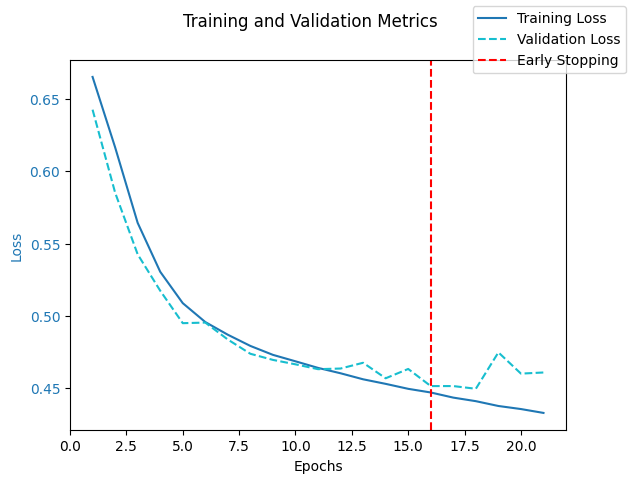


Training with seed 20
Early stopping at epoch 27.
Best Val F1: 0.7896.


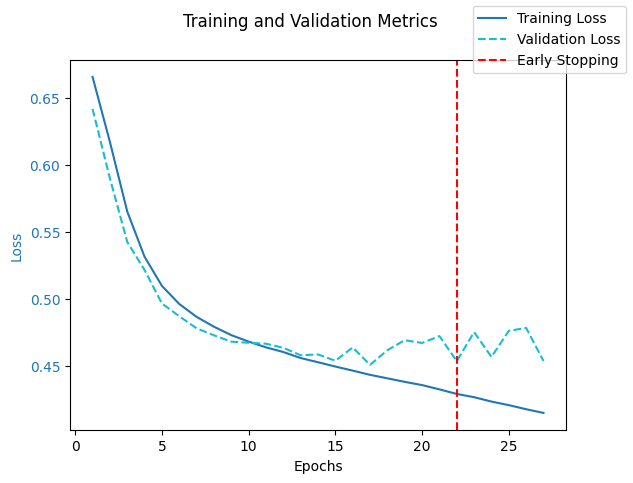


Training with seed 38
Early stopping at epoch 27.
Best Val F1: 0.7915.


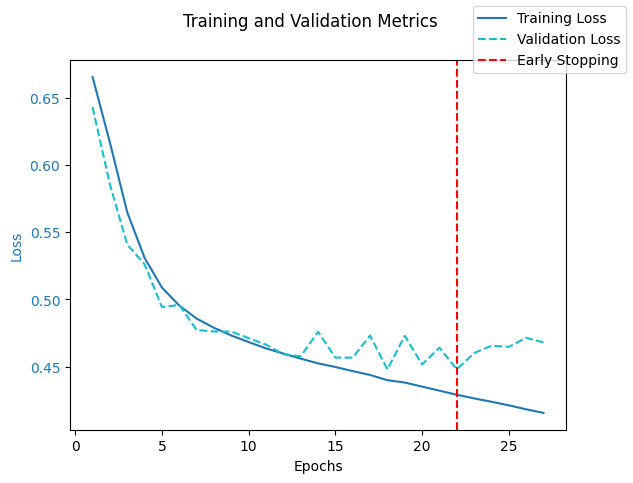


Training with seed 42
Early stopping at epoch 27.
Best Val F1: 0.7932.


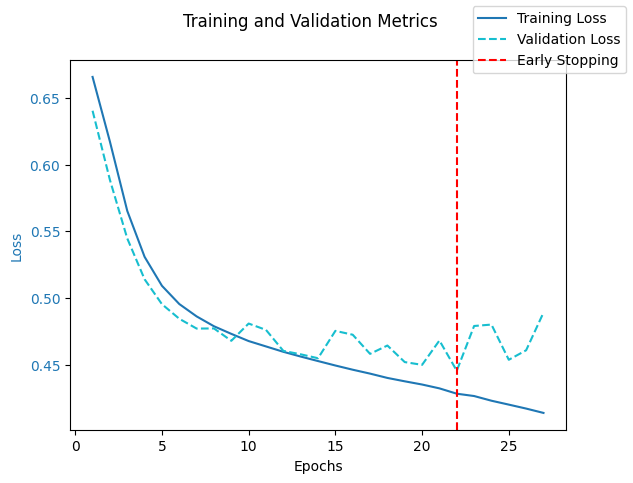


Training with seed 60
Early stopping at epoch 26.
Best Val F1: 0.7912.


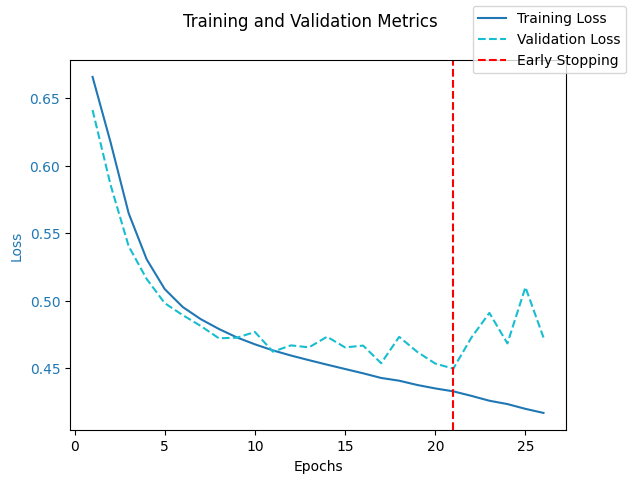

In [ ]:
main_training_rnn(x_train, y_train, x_val, y_val, input_size, hidden_size, num_layers, output_size, models_one_layer_rnn, learning_rate, num_epochs, batch_size)

- BiLSTM 1 layer training


Training with seed 5
Layer                                    Parameters     
lstm.weight_ih_l0                        12800          
lstm.weight_hh_l0                        4096           
lstm.bias_ih_l0                          128            
lstm.bias_hh_l0                          128            
lstm.weight_ih_l0_reverse                12800          
lstm.weight_hh_l0_reverse                4096           
lstm.bias_ih_l0_reverse                  128            
lstm.bias_hh_l0_reverse                  128            
fc.weight                                64             
fc.bias                                  1              
Total Trainable Parameters: 34369
Early stopping at epoch 17.
Best Val F1: 0.8049.


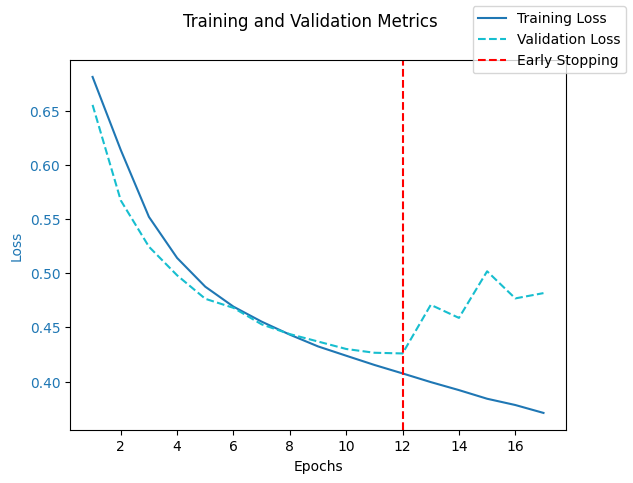


Training with seed 20
Early stopping at epoch 17.
Best Val F1: 0.7995.


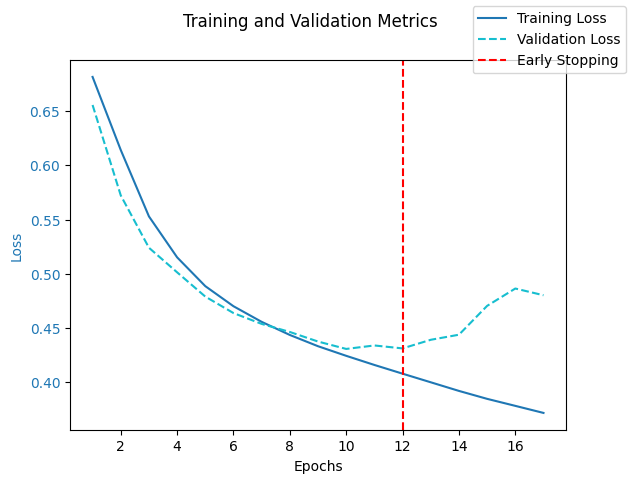


Training with seed 38
Early stopping at epoch 17.
Best Val F1: 0.7996.


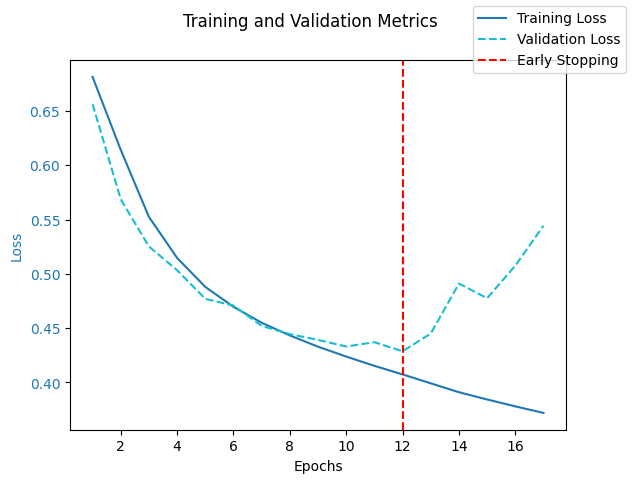


Training with seed 42
Early stopping at epoch 18.
Best Val F1: 0.7993.


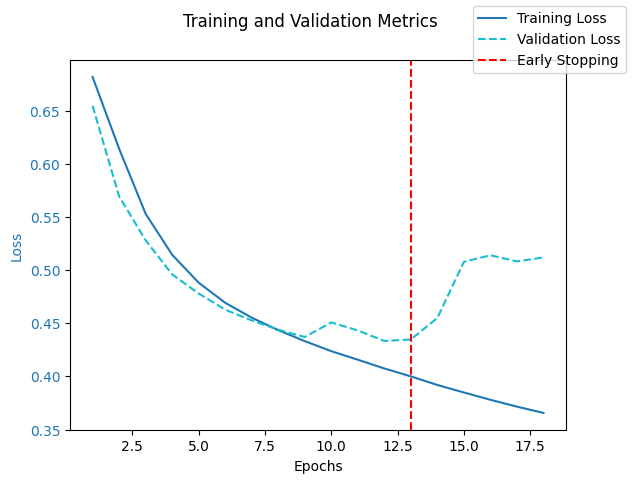


Training with seed 60
Early stopping at epoch 16.
Best Val F1: 0.8025.


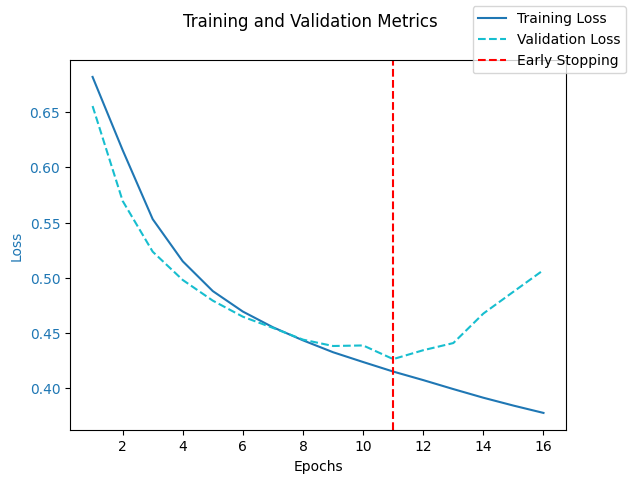

In [ ]:
main_training_lstm(x_train, y_train, x_val, y_val, input_size, hidden_size, num_layers, output_size, models_one_layer_lstm, learning_rate, num_epochs, batch_size)

# Evaluation of 1 layer models

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def evaluate_models(models, x_test, y_test, batch_size=128, device = device):
    accuracies, f1_scores = [], []
    for i, model in enumerate(models):
        test_accuracy, test_f1 = evaluate_bilstm_model(model, x_test, y_test, batch_size=128, device = device)
        accuracies.append(test_accuracy)
        f1_scores.append(test_f1)
        print(f"Model {i + 1}:")
        print(f"  Test Accuracy: {test_accuracy:.4f}")
        print(f"  Test F1 Score: {test_f1:.4f}\n")

    average_accuracy = np.mean(accuracies)
    average_f1 = np.mean(f1_scores)
    #std_accuracy = np.std(accuracies)
    #std_f1 = np.std(f1_scores)
    print(f"Average Accuracy: {average_accuracy:.4f}")
    print(f"Average F1 Score: {average_f1:.4f}\n")
    #print(f"Standard Deviation Accuracy: {std_accuracy:.4f}")
    #print(f"Standard Deviation F1 Score: {std_f1:.4f}")

- 1 Layer BiRNN evaluation

In [ ]:
evaluate_models(models_one_layer_rnn, x_test, y_test, batch_size=128, device=device)

Model 1:
  Test Accuracy: 0.7810
  Test F1 Score: 0.7803

Model 2:
  Test Accuracy: 0.7814
  Test F1 Score: 0.7808

Model 3:
  Test Accuracy: 0.7742
  Test F1 Score: 0.7741

Model 4:
  Test Accuracy: 0.7619
  Test F1 Score: 0.7618

Model 5:
  Test Accuracy: 0.7705
  Test F1 Score: 0.7705

Model 6:
  Test Accuracy: 0.7810
  Test F1 Score: 0.7803

Model 7:
  Test Accuracy: 0.7814
  Test F1 Score: 0.7808

Model 8:
  Test Accuracy: 0.7742
  Test F1 Score: 0.7741

Model 9:
  Test Accuracy: 0.7619
  Test F1 Score: 0.7618

Model 10:
  Test Accuracy: 0.7705
  Test F1 Score: 0.7705

Average Accuracy: 0.7738
Average F1 Score: 0.7735



- 1 Layer BiLSTM evaluation

In [ ]:
evaluate_models(models_one_layer_lstm, x_test, y_test, batch_size=128, device=device)

Model 1:
  Test Accuracy: 0.7877
  Test F1 Score: 0.7877

Model 2:
  Test Accuracy: 0.7877
  Test F1 Score: 0.7877

Model 3:
  Test Accuracy: 0.7873
  Test F1 Score: 0.7873

Model 4:
  Test Accuracy: 0.7544
  Test F1 Score: 0.7533

Model 5:
  Test Accuracy: 0.7705
  Test F1 Score: 0.7701

Model 6:
  Test Accuracy: 0.7697
  Test F1 Score: 0.7694

Average Accuracy: 0.7762
Average F1 Score: 0.7759



I stored the errors of the model that performed better between RNN and LSTM

In [ ]:
one_layer_error_df,score_one_layer,target_one_layer,predicted_one_layer= collect_errors(models_one_layer_lstm[0], x_test, y_test ,test_df_embedded, batch_size=128)

#**BiRNN and BiLSTM (num_layer = 2) TRAINING and EVALUATION**

- BiRNN 2 layers training


Training with seed 5
Layer                                    Parameters     
rnn.weight_ih_l0                         3200           
rnn.weight_hh_l0                         1024           
rnn.bias_ih_l0                           32             
rnn.bias_hh_l0                           32             
rnn.weight_ih_l0_reverse                 3200           
rnn.weight_hh_l0_reverse                 1024           
rnn.bias_ih_l0_reverse                   32             
rnn.bias_hh_l0_reverse                   32             
rnn.weight_ih_l1                         2048           
rnn.weight_hh_l1                         1024           
rnn.bias_ih_l1                           32             
rnn.bias_hh_l1                           32             
rnn.weight_ih_l1_reverse                 2048           
rnn.weight_hh_l1_reverse                 1024           
rnn.bias_ih_l1_reverse                   32             
rnn.bias_hh_l1_reverse                   32             
fc.weight

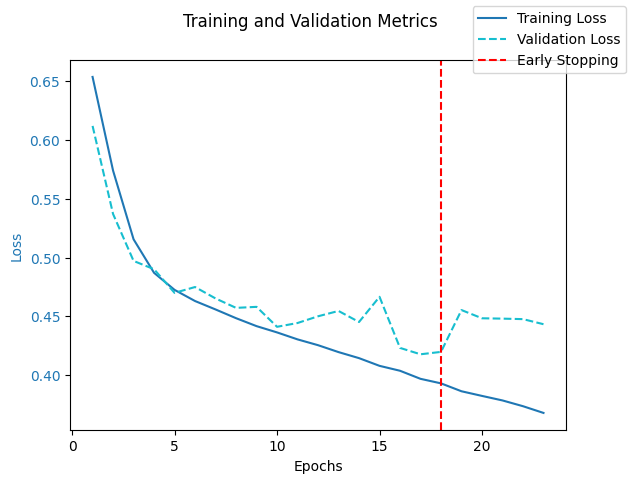


Training with seed 20
Early stopping at epoch 22.
Best Val F1: 0.8070.


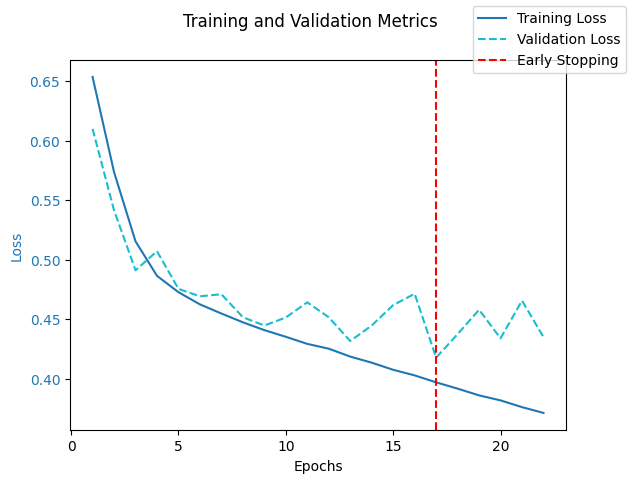


Training with seed 38
Early stopping at epoch 31.
Best Val F1: 0.8183.


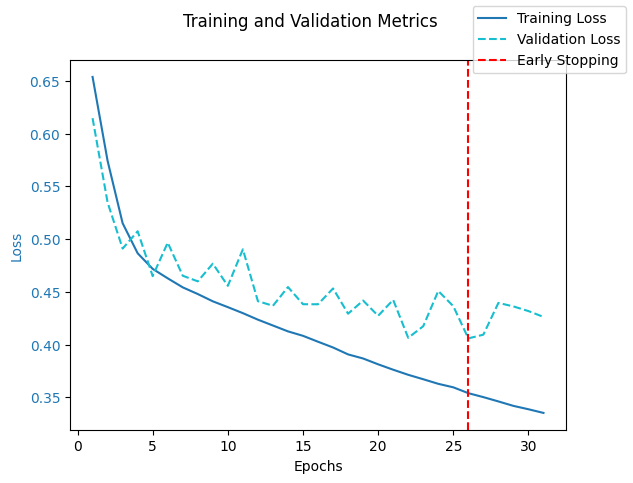


Training with seed 42
Early stopping at epoch 25.
Best Val F1: 0.8134.


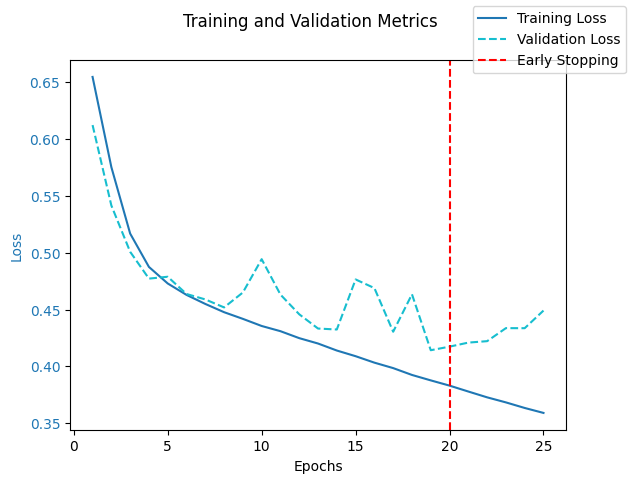


Training with seed 60
Early stopping at epoch 26.
Best Val F1: 0.8127.


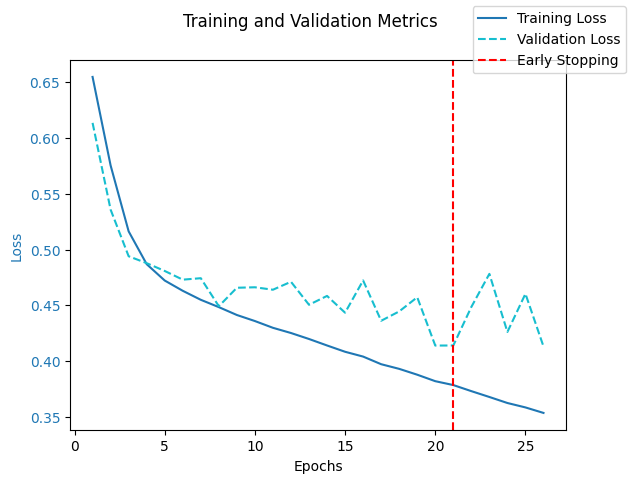

In [ ]:
num_layers = 2
models_2l_rnn = []
main_training_rnn(x_train, y_train, x_val, y_val, input_size, hidden_size, num_layers, output_size, models_2l_rnn, learning_rate,num_epochs,batch_size)

- BiLSTM 2 layers training


Training with seed 5
Layer                                    Parameters     
lstm.weight_ih_l0                        12800          
lstm.weight_hh_l0                        4096           
lstm.bias_ih_l0                          128            
lstm.bias_hh_l0                          128            
lstm.weight_ih_l0_reverse                12800          
lstm.weight_hh_l0_reverse                4096           
lstm.bias_ih_l0_reverse                  128            
lstm.bias_hh_l0_reverse                  128            
lstm.weight_ih_l1                        8192           
lstm.weight_hh_l1                        4096           
lstm.bias_ih_l1                          128            
lstm.bias_hh_l1                          128            
lstm.weight_ih_l1_reverse                8192           
lstm.weight_hh_l1_reverse                4096           
lstm.bias_ih_l1_reverse                  128            
lstm.bias_hh_l1_reverse                  128            
fc.weight

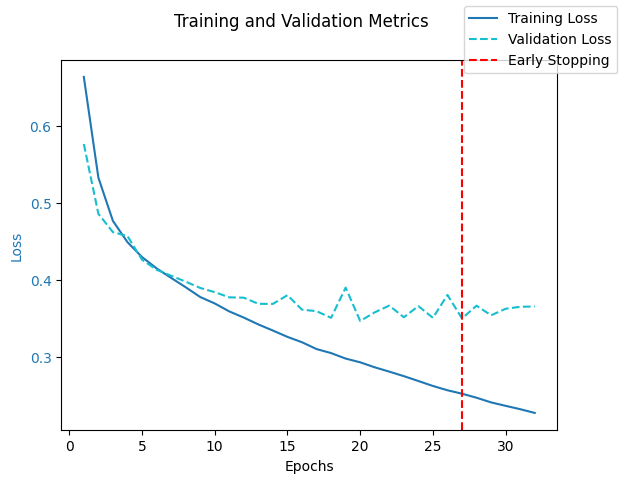


Training with seed 20
Early stopping at epoch 30.
Best Val F1: 0.8512.


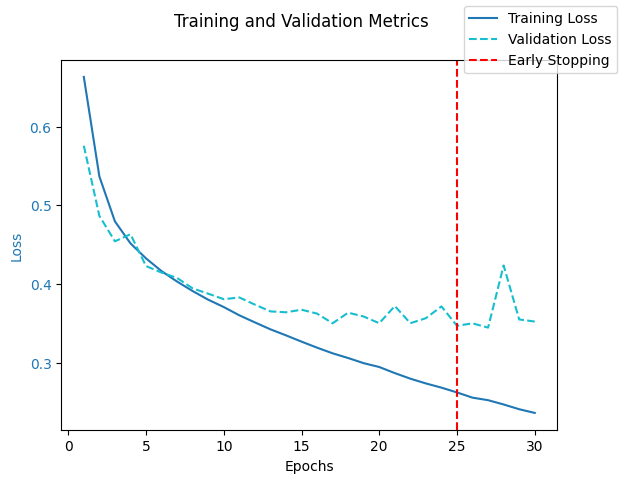


Training with seed 38
Early stopping at epoch 33.
Best Val F1: 0.8556.


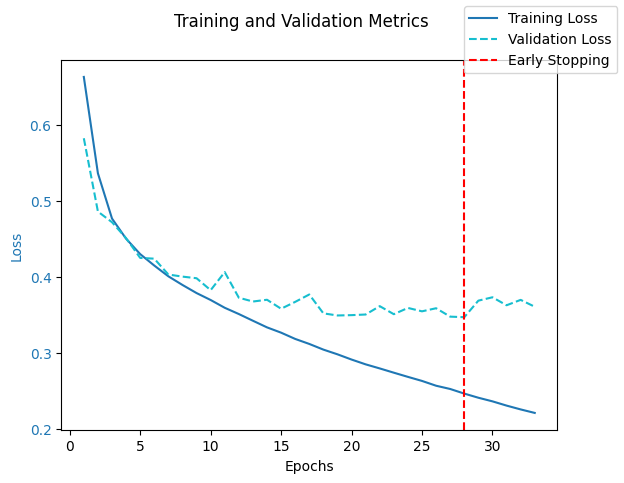


Training with seed 42
Early stopping at epoch 28.
Best Val F1: 0.8498.


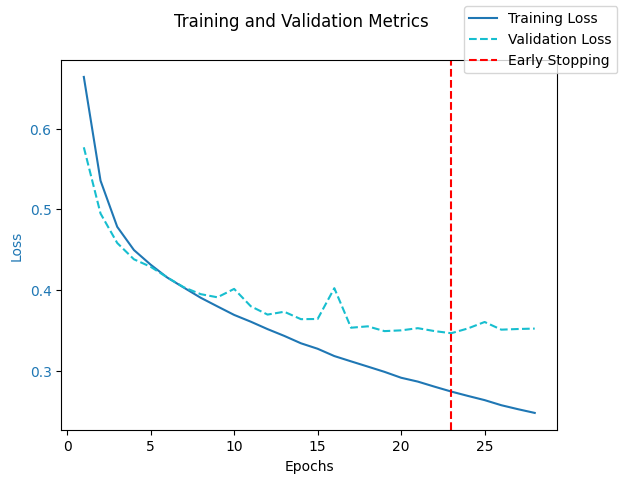


Training with seed 60
Early stopping at epoch 44.
Best Val F1: 0.8536.


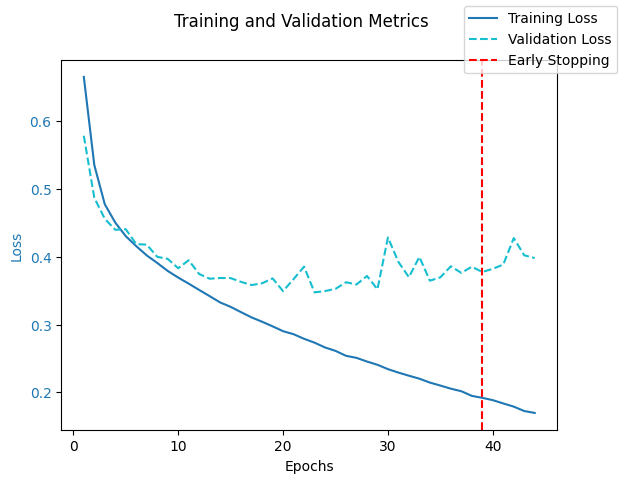

In [ ]:
num_layers = 2
models_2l_lstm = []
main_training_lstm(x_train, y_train, x_val, y_val, input_size, hidden_size, num_layers, output_size,models_2l_lstm, learning_rate,num_epochs,batch_size)

# Evaluation of 2 layers models

- 2 Layers BiRNN evaluation

In [ ]:
evaluate_models(models_2l_rnn, x_test, y_test, batch_size=128, device=device)

Model 1:
  Test Accuracy: 0.7915
  Test F1 Score: 0.7915

Model 2:
  Test Accuracy: 0.7900
  Test F1 Score: 0.7900

Model 3:
  Test Accuracy: 0.8027
  Test F1 Score: 0.8027

Model 4:
  Test Accuracy: 0.7821
  Test F1 Score: 0.7821

Model 5:
  Test Accuracy: 0.8027
  Test F1 Score: 0.8026

Average Accuracy: 0.7938
Average F1 Score: 0.7937



- 2 Layers BiLSTM evaluation

In [ ]:
evaluate_models(models_2l_lstm, x_test, y_test, batch_size=128, device=device)

Model 1:
  Test Accuracy: 0.8491
  Test F1 Score: 0.8479

Model 2:
  Test Accuracy: 0.8476
  Test F1 Score: 0.8466

Model 3:
  Test Accuracy: 0.8443
  Test F1 Score: 0.8426

Model 4:
  Test Accuracy: 0.8420
  Test F1 Score: 0.8384

Model 5:
  Test Accuracy: 0.8480
  Test F1 Score: 0.8466

Average Accuracy: 0.8462
Average F1 Score: 0.8444



In [ ]:
two_layers_error_df,score_two_layers,target_two_layers,predicted_two_layers = collect_errors(models_2l_lstm[0], x_test, y_test,test_df_embedded, batch_size=128)

#Transformer
In this section, I opted for a transformer encoder-only model to solve this task due to its pre-trained nature and advanced ability to process token sequences. The attention mechanism in this model should capture the semantic context of the input sequences more efficiently than the architectures used before, making it particularly suitable for the task. The transformer used is **BERT-base-uncased**, sourced from the Hugging Face Transformers library. This pre-trained model is optimized for sequence classification tasks and can be further fine-tuned to meet specific needs.



### Working Flow
1. I loaded the Tokenizer and Model

2. Preprocess the Dataset

3. Fine tuning of the Model

4. Evaluation

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 w

USEFUL IMPORTS

In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request
from datasets import Dataset
from transformers import TrainingArguments
from transformers import DataCollatorWithPadding
from transformers import Trainer
from sklearn.metrics import f1_score, accuracy_score

**1.** Load the Tokenizer and Model

In [ ]:
# to run only once
MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
transformer_model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
transformer_model.save_pretrained(MODEL_NAME)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**2.** Preprocess the Dataset

In [ ]:
train_df = original_train_df.copy()
validation_df = original_validation_df.copy()
test_df = original_test_df.copy()

same cleaning process as before

In [ ]:
# Function to clean headline
def clean_headline_transformer(headline):
    # Remove special characters and symbols
    headline = re.sub(r'[^a-zA-Z0-9\s]', '', headline)
    # Remove specific quote characters (curly quotes, etc.)
    headline = headline.replace('“', '').replace('”', '').replace('‘', '').replace('’', '')
    # Convert to lowercase
    headline = headline.lower()
    return headline

In [ ]:
print(train_df['headline'][0])
# Apply the cleaning function to the 'headline' column
train_df['headline'] = train_df['headline'].apply(clean_headline_transformer)
validation_df['headline'] = validation_df['headline'].apply(clean_headline_transformer)
test_df['headline'] = test_df['headline'].apply(clean_headline_transformer)
print(train_df['headline'][0])

former versace store clerk sues over secret 'black code' for minority shoppers
former versace store clerk sues over secret black code for minority shoppers


In [ ]:
def preprocess_text(texts):
    return tokenizer(texts['headline'], truncation=True)

train_data = Dataset.from_pandas(train_df)
validation_data = Dataset.from_pandas(validation_df)
test_data = Dataset.from_pandas(test_df)

train_data = train_data.map(preprocess_text, batched=True)
validation_data = validation_data.map(preprocess_text, batched=True)
test_data = test_data.map(preprocess_text, batched=True)
train_data

Map:   0%|          | 0/16414 [00:00<?, ? examples/s]

Map:   0%|          | 0/5342 [00:00<?, ? examples/s]

Map:   0%|          | 0/2671 [00:00<?, ? examples/s]

Dataset({
    features: ['headline', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 16414
})

**3.** Fine tuning of the Model

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
def compute_metrics(output_info):
    predictions, labels = output_info
    predictions = np.argmax(predictions, axis=-1)

    f1 = f1_score(y_pred=predictions, y_true=labels, average='macro')
    acc = accuracy_score(y_pred=predictions, y_true=labels)
    return {'f1': f1, 'acc': acc}

In [ ]:
training_args = TrainingArguments(
    output_dir="test_dir",
    learning_rate= 2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to='none'
)

In [ ]:
trainer = Trainer(
    model=transformer_model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=validation_data,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [ ]:
#2 epochs
trainer.train()

TrainOutput(global_step=4104, training_loss=0.25306895741245206, metrics={'train_runtime': 403.1036, 'train_samples_per_second': 81.438, 'train_steps_per_second': 10.181, 'total_flos': 320418904328040.0, 'train_loss': 0.25306895741245206, 'epoch': 2.0})

4. Evaluation of the Model (F1-macro)

In [ ]:
test_prediction_info = trainer.predict(test_data)
test_predictions, test_labels = test_prediction_info.predictions, test_prediction_info.label_ids

In [ ]:
test_metrics = compute_metrics([test_predictions, test_labels])
print(test_metrics)

{'f1': 0.9224619598503667, 'acc': 0.9236241108199177}


In [ ]:
def collect_errors_transf(trainer, test_data, test_df, batch_size=128):
    texts = test_df['headline']
    test_prediction_info = trainer.predict(test_data)
    test_predictions, test_labels = test_prediction_info.predictions, test_prediction_info.label_ids
    test_predictions = np.argmax(test_predictions, axis=-1)

    error_texts = []
    labels = []
    error_label = []

    for i, (pred, label) in enumerate(zip(test_predictions, test_labels)):
        if pred != label:
            error_texts.append(texts.iloc[i])
            labels.append(label)
            error_label.append(pred)

    errors_df = pd.DataFrame({'headline': error_texts,'true_label': labels,'predicted_label': error_label})
    return errors_df

In [ ]:
transformer_error_df = collect_errors_transf(trainer, test_data, test_df_embedded)

# **ANALYSIS OF THE OBTAINED RESULTS**


In [ ]:
train_df = original_train_df.copy()
validation_df = original_validation_df.copy()
test_df = original_test_df.copy()

## Error Distribution Across Both Classes
I began by analyzing the label distribution in the available datasets and comparing it to the distribution of the true labels among the errors of each model. From this analysis, it can be observed that significant performance improvements occur whenever we use a model capable of processing inputs in a more sophisticated manner. In particular, the transformer achieves the most substantial reduction in the error rate. The performance of the two BiLSTM models, with 1 and 2 layers, suggests that adding an extra layer can indeed enable a better representation of the sequence's context. In our specific case, this results in a notable decrease in errors when misclassifying headlines as non-sarcastic.


Train dataset:
Label 1: 8207 (50.00%)
Label 0: 8207 (50.00%)

Validation dataset:
Label 0: 3001 (56.18%)
Label 1: 2341 (43.82%)

Test dataset:
Label 0: 1495 (55.97%)
Label 1: 1176 (44.03%)

1 layer model errors:
Label 0.0: 453 (79.89%)
Label 1.0: 114 (20.11%)

2 layers model errors:
Label 0.0: 240 (59.55%)
Label 1.0: 163 (40.45%)

Transformer errors:
Label 1.0: 106 (51.96%)
Label 0.0: 98 (48.04%)


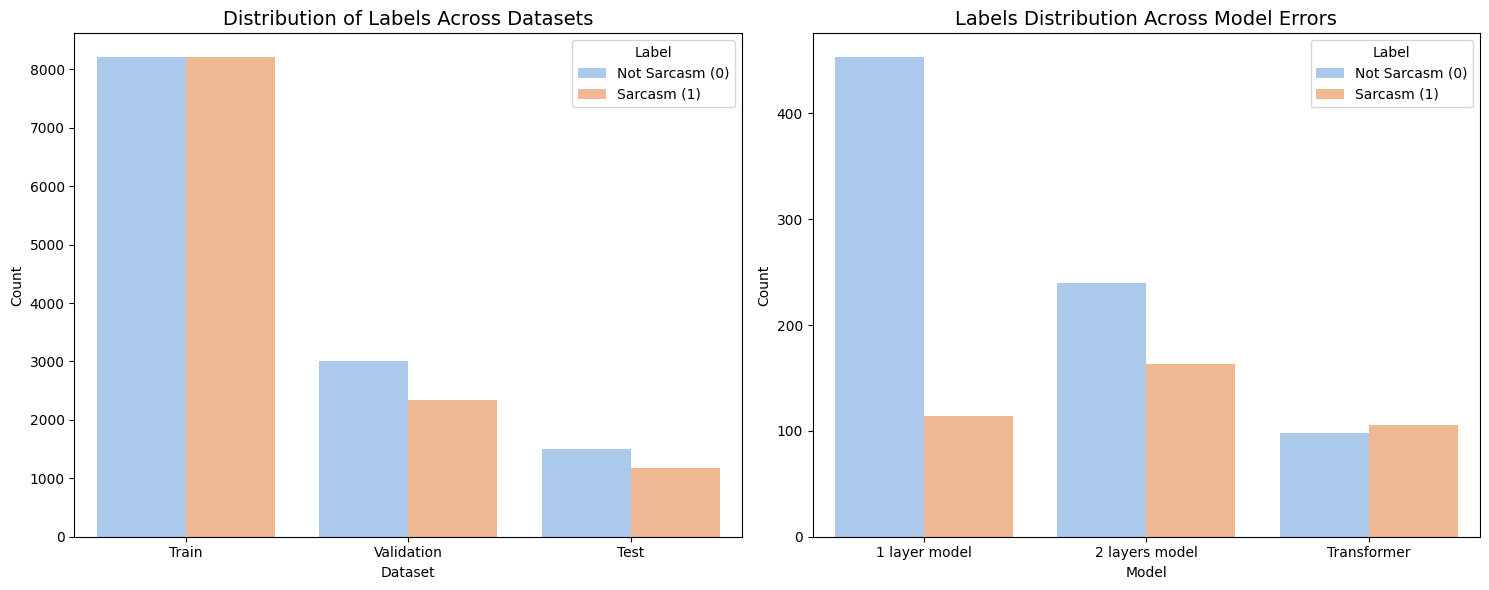

In [ ]:
import seaborn as sns
train_df['Dataset'] = 'Train'
validation_df['Dataset'] = 'Validation'
test_df['Dataset'] = 'Test'

def print_label_distribution(df, dataset_name):
    counts = df['label'].value_counts()
    total = counts.sum()
    print(f'\n{dataset_name} dataset:')
    for label, count in counts.items():
        percentage = (count / total) * 100
        print(f"Label {label}: {count} ({percentage:.2f}%)")

print_label_distribution(train_df, "Train")
print_label_distribution(validation_df, "Validation")
print_label_distribution(test_df, "Test")

combined_df_datasets = pd.concat([train_df, validation_df, test_df])

true_labels_baseline = one_layer_error_df['true_label']
true_labels_model1 = two_layers_error_df['true_label']
true_labels_transformer = transformer_error_df['true_label']

combined_df_models = pd.DataFrame({
    'Dataset': ['1 layer model'] * len(true_labels_baseline) +['2 layers model'] * len(true_labels_model1) +['Transformer'] * len(true_labels_transformer),
    'label': true_labels_baseline.tolist() + true_labels_model1.tolist() + true_labels_transformer.tolist()
})

def print_label_distribution_for_models(df):
    datasets = df['Dataset'].unique()
    for dataset in datasets:
        subset = df[df['Dataset'] == dataset]
        counts = subset['label'].value_counts()
        total = counts.sum()
        print(f'\n{dataset} errors:')
        for label, count in counts.items():
            percentage = (count / total) * 100
            print(f"Label {label}: {count} ({percentage:.2f}%)")

print_label_distribution_for_models(combined_df_models)

fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=False)

sns.countplot(data=combined_df_datasets, x='Dataset', hue='label', palette='pastel', ax=axes[0])
axes[0].set_title('Distribution of Labels Across Datasets', fontsize=14)
axes[0].set_xlabel('Dataset')
axes[0].set_ylabel('Count')
axes[0].legend(title='Label', labels=['Not Sarcasm (0)', 'Sarcasm (1)'], fontsize=10)

sns.countplot(data=combined_df_models,x='Dataset',hue='label',palette='pastel',ax=axes[1])
axes[1].set_title("Labels Distribution Across Model Errors", fontsize=14)
axes[1].set_xlabel("Model")
axes[1].set_ylabel("Count")
axes[1].legend(title='Label', labels=['Not Sarcasm (0)', 'Sarcasm (1)'], fontsize=10)

plt.tight_layout()
plt.show()

## **CONFUSION MATRIX AND PRECISION-RECALL CURVE**
I show here the confusion matrix and the precision-recal curve for all the three models.

In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def plot_evaluation_metrics(all_predictions, all_targets, model_name, predictions, transformer):
    # Set consistent style
    sns.set(style="whitegrid")

    # Create a figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1, 1.5]})

    # Confusion Matrix
    cm = confusion_matrix(all_targets, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
    axes[0].set_title(f'Confusion Matrix - {model_name}', fontsize=12)
    axes[0].set_xlabel('Predicted Label', fontsize=10)
    axes[0].set_ylabel('True Label', fontsize=10)

    # Precision-Recall Curve
    if transformer:
        precision, recall, thresholds = precision_recall_curve(all_targets, all_predictions[:, 1])
    else:
        precision, recall, thresholds = precision_recall_curve(all_targets, all_predictions)

    axes[1].plot(recall, precision, label='Precision-Recall Curve', color='blue')
    axes[1].fill_between(recall, precision, alpha=0.2, color='skyblue')

    # Add thresholds annotations
    step = max(1, len(thresholds) // 10)
    for i in range(0, len(thresholds), step):
        axes[1].annotate(f'{thresholds[i]:.2f}',
                         (recall[i], precision[i]),
                         textcoords="offset points", xytext=(-10, 10), ha='center', fontsize=8,
                         color='red', arrowprops=dict(arrowstyle='->', color='red', lw=0.5))

    axes[1].set_title(f'Precision-Recall Curve - {model_name}', fontsize=12)
    axes[1].set_xlabel('Recall', fontsize=10)
    axes[1].set_ylabel('Precision', fontsize=10)
    axes[1].legend(loc='lower left', fontsize=9)

    plt.tight_layout()
    plt.show()

    # Print Classification Report
    print('\n')
    print(f'Classification Report - {model_name}')
    print(classification_report(all_targets, predictions, digits=2))

In [ ]:
predictions_trans = np.argmax(test_predictions, axis=-1)

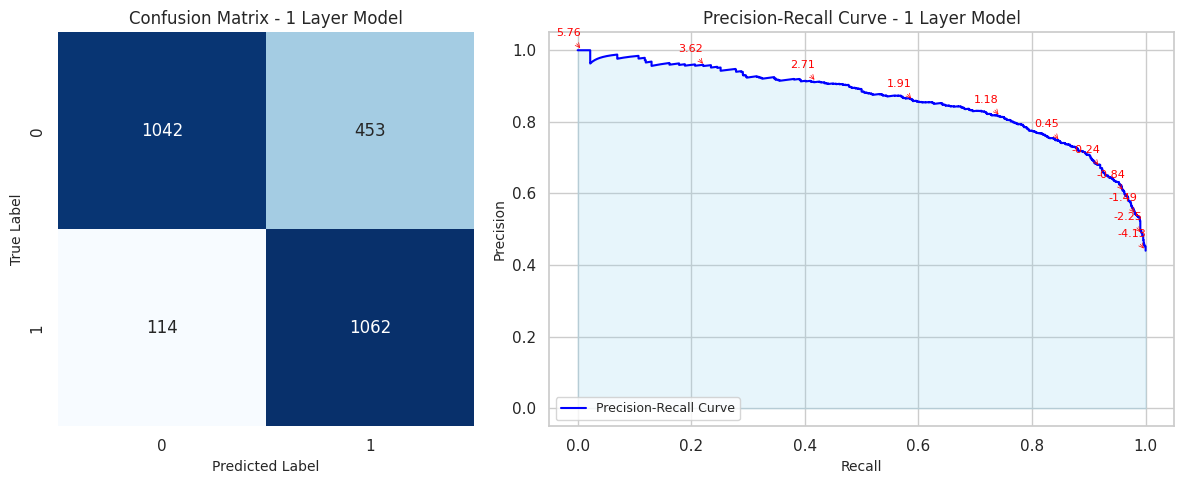



Classification Report - 1 Layer Model
              precision    recall  f1-score   support

         0.0       0.90      0.70      0.79      1495
         1.0       0.70      0.90      0.79      1176

    accuracy                           0.79      2671
   macro avg       0.80      0.80      0.79      2671
weighted avg       0.81      0.79      0.79      2671



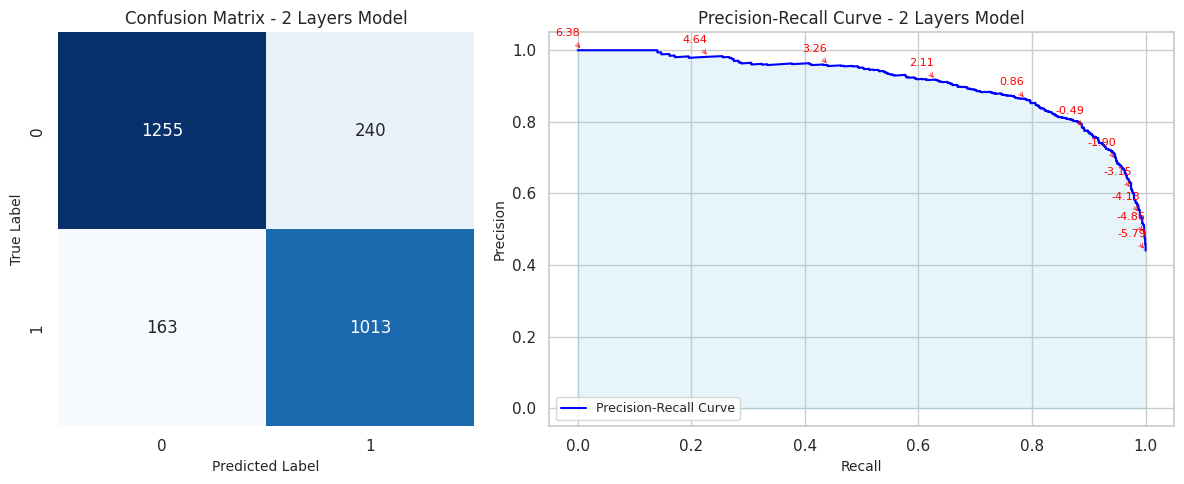



Classification Report - 2 Layers Model
              precision    recall  f1-score   support

         0.0       0.89      0.84      0.86      1495
         1.0       0.81      0.86      0.83      1176

    accuracy                           0.85      2671
   macro avg       0.85      0.85      0.85      2671
weighted avg       0.85      0.85      0.85      2671



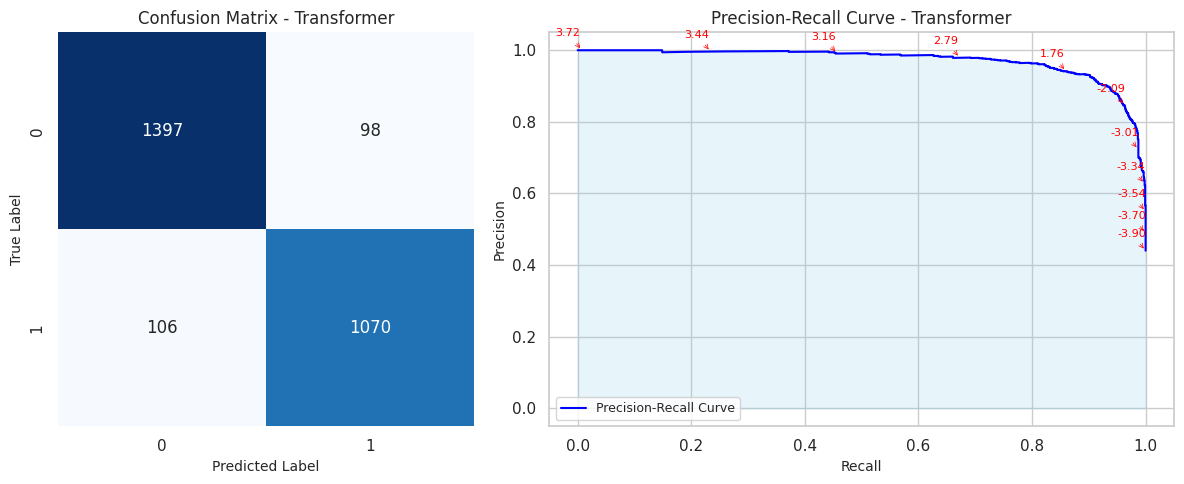



Classification Report - Transformer
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1495
           1       0.92      0.91      0.91      1176

    accuracy                           0.92      2671
   macro avg       0.92      0.92      0.92      2671
weighted avg       0.92      0.92      0.92      2671



In [ ]:
plot_evaluation_metrics(score_one_layer,target_one_layer,'1 Layer Model',predicted_one_layer,transformer=False)
plot_evaluation_metrics(score_two_layers,target_two_layers,'2 Layers Model',predicted_two_layers,transformer=False)
plot_evaluation_metrics(test_predictions, test_labels,'Transformer',predictions_trans,transformer=True)

## **HEADLINE LENGTH**
I compared the lenght of the headlines in the test set and the lenght of the misclassified headlines. From this analysis, we can observe that the distribution of headline lengths in the dataset is similar to that of the headlines incorrectly classified by both the transformer and the BiLSTM model with 1 layer. This suggests that sequence length was not a significant obstacle, as the error distribution consistently follows that of the test set, without showing, for example, a higher concentration of errors for longer sequences.

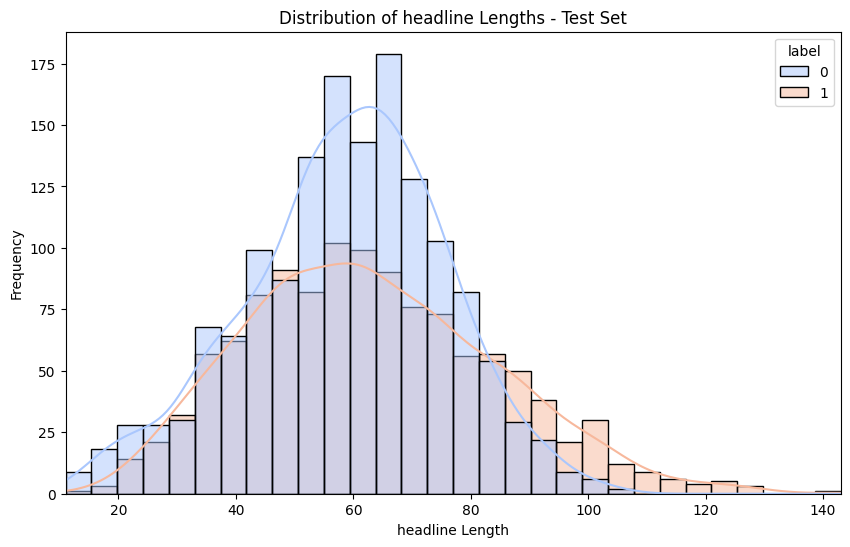

In [ ]:
def plot_distr_len(data_list_or, labels):
    data_list = []
    for data_or in data_list_or:
        data = data_or.copy()
        data['headline_length'] = data['headline'].apply(len)
        data_list.append(data)

    all_lengths = pd.concat([data['headline_length'] for data in data_list])
    x_min, x_max = all_lengths.min(), all_lengths.max()

    for i, data in enumerate(data_list):
        plt.figure(figsize=(10, 6))
        sns.histplot(data, x='headline_length', hue='label', bins=30, kde=True, palette='coolwarm')
        plt.title(f'Distribution of headline Lengths - {labels[i]}')
        plt.xlabel('headline Length')
        plt.ylabel('Frequency')
        plt.xlim(x_min, x_max)
        plt.show()

plot_distr_len([test_df], labels=['Test Set'])

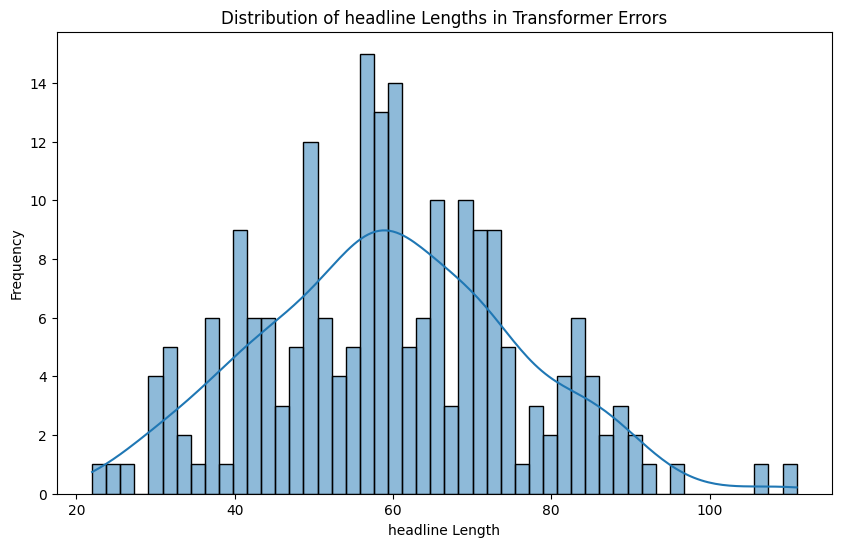

In [ ]:
transformer_error_df['headline_length'] = transformer_error_df['headline'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(transformer_error_df['headline_length'], bins=50, kde=True,)
plt.title('Distribution of headline Lengths in Transformer Errors')
plt.xlabel('headline Length')
plt.ylabel('Frequency')
plt.show()

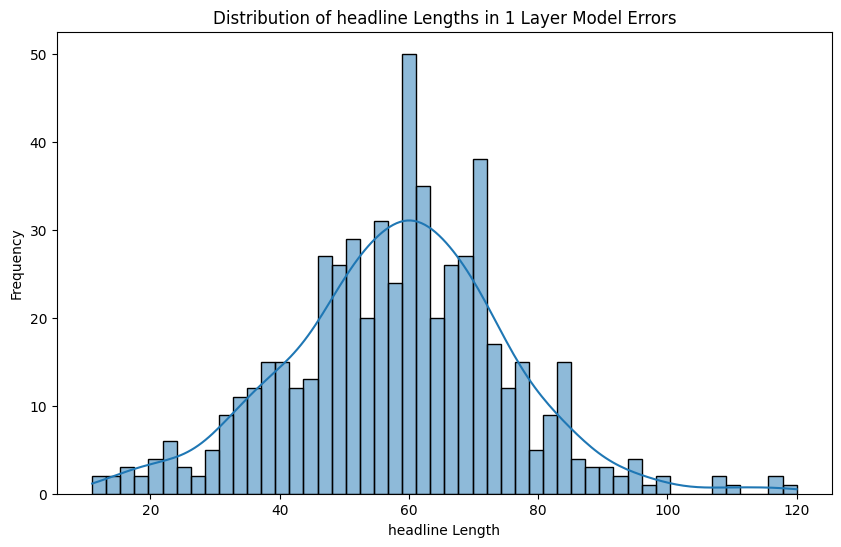

In [ ]:
one_layer_error_df['headline_length'] = one_layer_error_df['headline'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(one_layer_error_df['headline_length'], bins=50, kde=True,)
plt.title('Distribution of headline Lengths in 1 Layer Model Errors')
plt.xlabel('headline Length')
plt.ylabel('Frequency')
plt.show()

## **MOST FREQUENT WORDS IN THE WRONG PREDICTIONS**<br>
Below, I have plotted the most frequent words in the incorrect predictions. As for the bigrams and trigrams, no significant recurring patterns stand out to help understand what might have led to the incorrect interpretation of the headline.

In [ ]:
import pandas as pd
from collections import Counter
import string
import matplotlib.pyplot as plt
from itertools import islice


def get_top_ngrams_by_label(df, text_column, label_column, top_n_words=15, top_n_bigrams=20, top_n_trigrams=15, stop_words=None):
    if stop_words is None:
        stop_words = []

    def preprocess_text(text):
        return text.translate(str.maketrans('', '', string.punctuation)).lower()

    def generate_ngrams(text, n):
        words = text.split()
        return zip(*[islice(words, i, None) for i in range(n)])

    df[text_column] = df[text_column].apply(preprocess_text)

    label_ngram_counts = {}
    for label in df[label_column].unique():
        texts = df[df[label_column] == label][text_column]
        all_words = " ".join(texts).split()
        filtered_words = [word for word in all_words if word not in stop_words]

        # Count unigrams, bigrams, and trigrams
        word_counts = Counter(filtered_words)
        bigram_counts = Counter(generate_ngrams(" ".join(filtered_words), 2))
        trigram_counts = Counter(generate_ngrams(" ".join(filtered_words), 3))

        label_ngram_counts[label] = {
            'words': word_counts.most_common(top_n_words),
            'bigrams': bigram_counts.most_common(top_n_bigrams),
            'trigrams': trigram_counts.most_common(top_n_trigrams),
        }

    return label_ngram_counts


def plot_top_ngrams(label_ngram_counts):
    for label, ngram_counts in label_ngram_counts.items():
        words, word_counts = zip(*ngram_counts['words'])
        bigrams, bigram_counts = zip(*ngram_counts['bigrams'])
        trigrams, trigram_counts = zip(*ngram_counts['trigrams'])

        # Convert bigrams and trigrams to strings for plotting
        bigrams = [" ".join(bigram) for bigram in bigrams]
        trigrams = [" ".join(trigram) for trigram in trigrams]

        # Create subplot
        fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
        fig.suptitle(f"Top words, bigrams, and trigrams for errors made in predicting label {label}", fontsize=16)

        # Plot words
        axes[0].bar(words, word_counts, color='skyblue')
        axes[0].set_title(f"Top 15 Words ({label})")
        axes[0].set_xticklabels(words, rotation=45, ha='right')
        axes[0].set_ylabel("Frequency")

        # Plot bigrams
        axes[1].bar(bigrams, bigram_counts, color='lightgreen')
        axes[1].set_title(f"Top 20 Bigrams ({label})")
        axes[1].set_xticklabels(bigrams, rotation=45, ha='right')

        # Plot trigrams
        axes[2].bar(trigrams, trigram_counts, color='salmon')
        axes[2].set_title(f"Top 15 Trigrams ({label})")
        axes[2].set_xticklabels(trigrams, rotation=45, ha='right')

        # Adjust layout
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

- Transformer

<ipython-input-67-49a254ca2678>:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(words, rotation=45, ha='right')
<ipython-input-67-49a254ca2678>:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(bigrams, rotation=45, ha='right')
<ipython-input-67-49a254ca2678>:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(trigrams, rotation=45, ha='right')


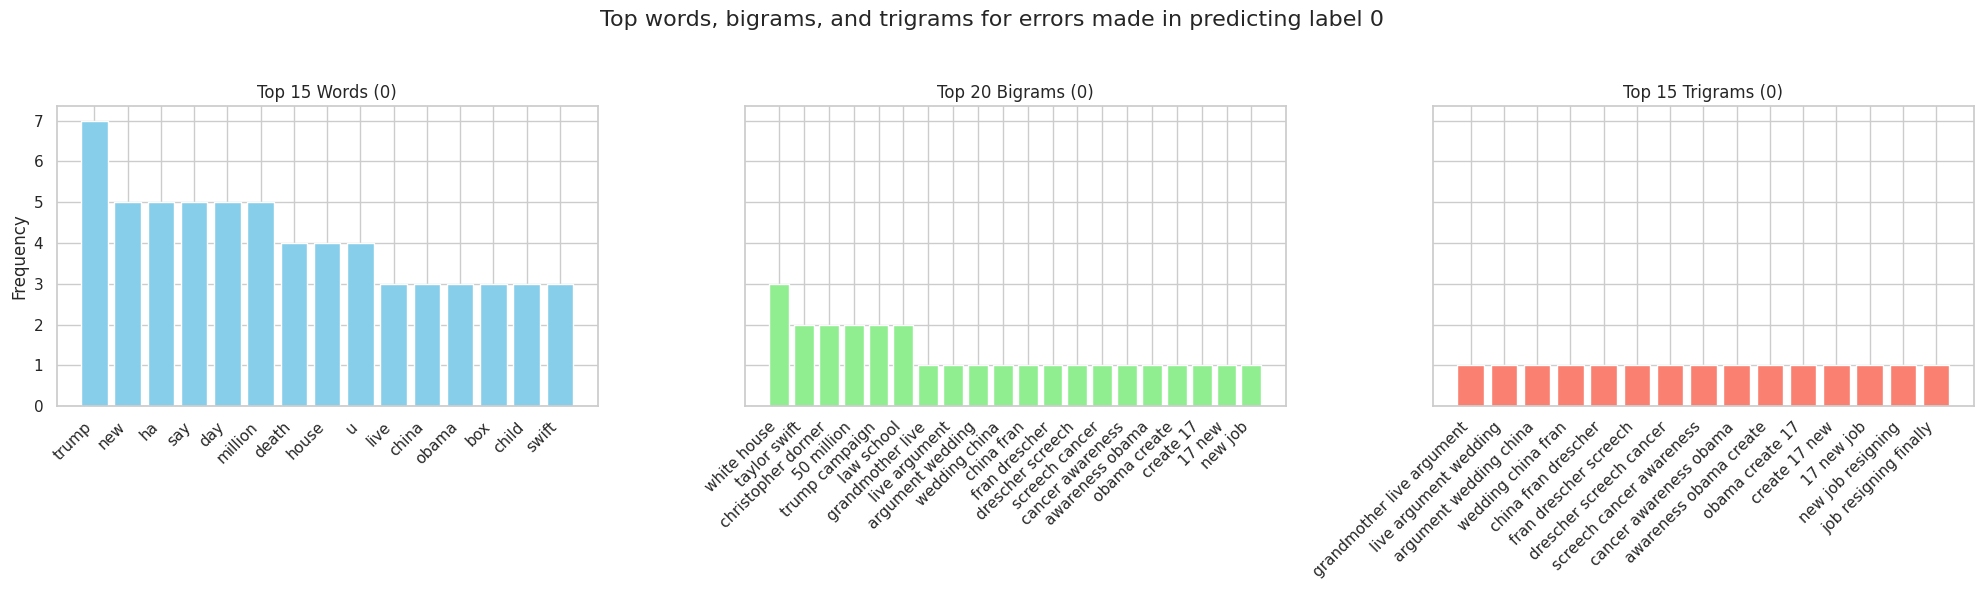

<ipython-input-67-49a254ca2678>:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(words, rotation=45, ha='right')
<ipython-input-67-49a254ca2678>:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(bigrams, rotation=45, ha='right')
<ipython-input-67-49a254ca2678>:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(trigrams, rotation=45, ha='right')


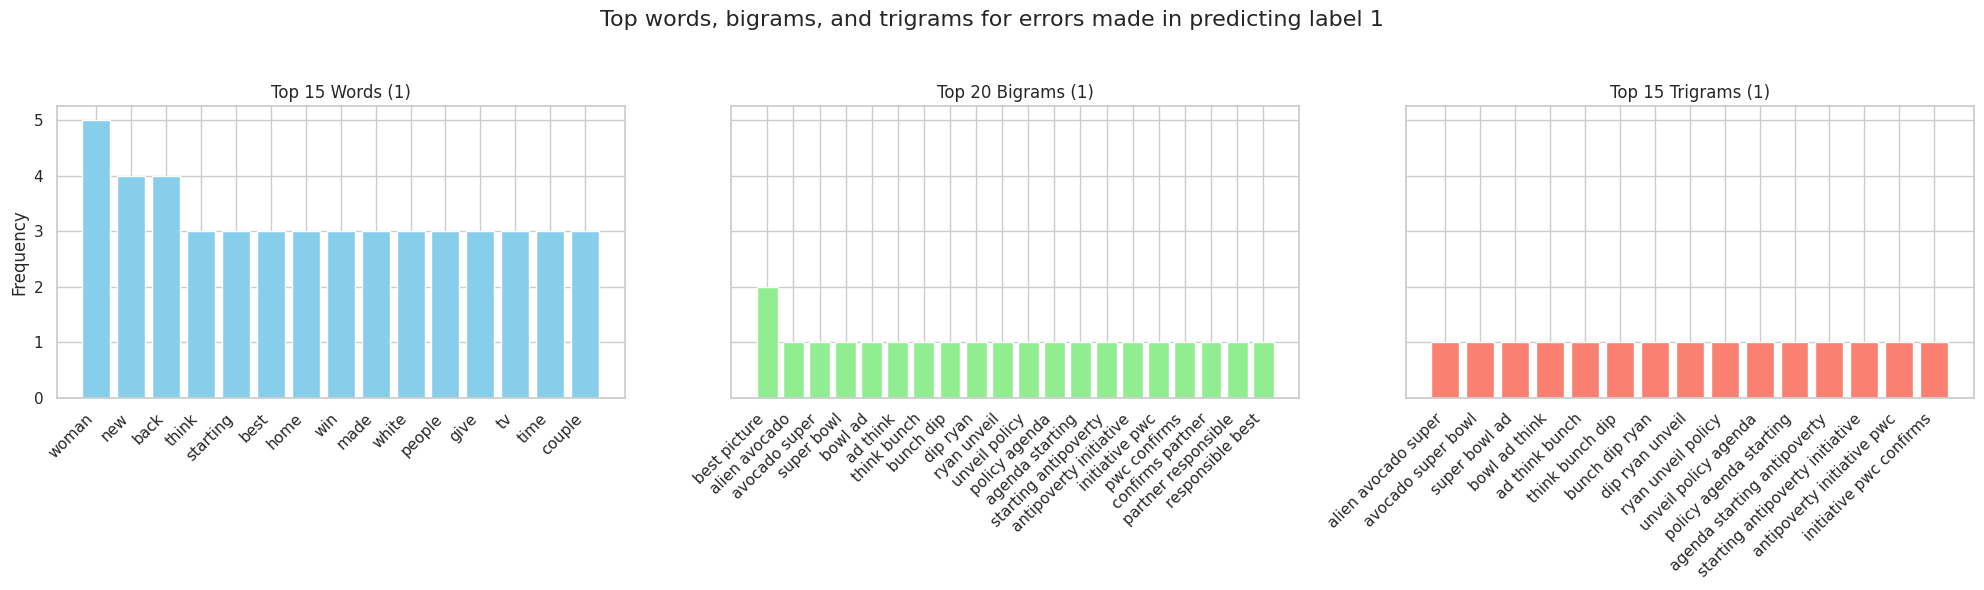

In [ ]:
stop_words = list(set(stopwords.words('english')))
label_ngram_counts = get_top_ngrams_by_label(transformer_error_df, text_column='headline', label_column='predicted_label', stop_words=stop_words)
plot_top_ngrams(label_ngram_counts)

- 2 layers BiLSTM

<ipython-input-67-49a254ca2678>:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(words, rotation=45, ha='right')
<ipython-input-67-49a254ca2678>:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(bigrams, rotation=45, ha='right')
<ipython-input-67-49a254ca2678>:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(trigrams, rotation=45, ha='right')


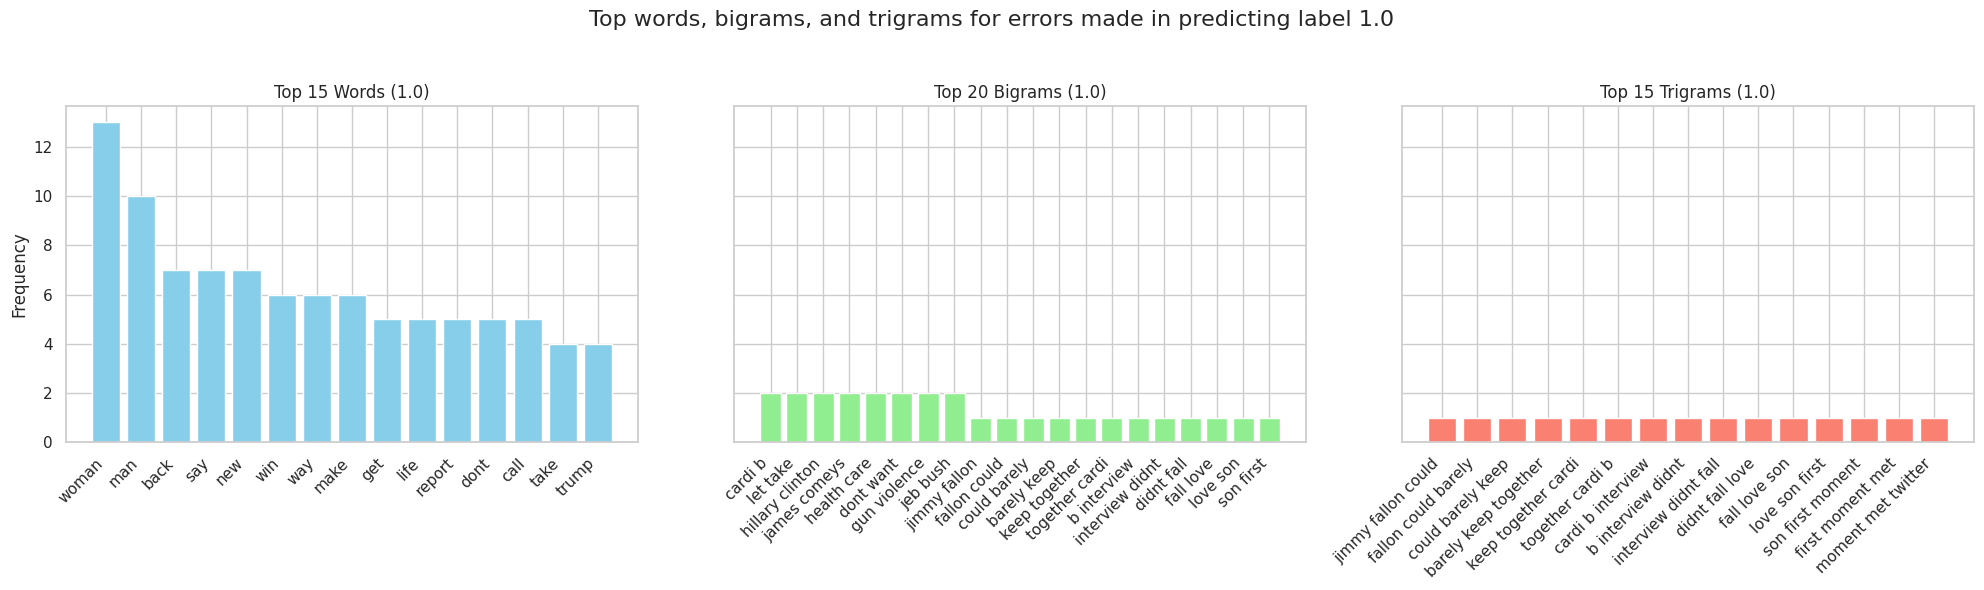

<ipython-input-67-49a254ca2678>:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(words, rotation=45, ha='right')
<ipython-input-67-49a254ca2678>:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(bigrams, rotation=45, ha='right')
<ipython-input-67-49a254ca2678>:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(trigrams, rotation=45, ha='right')


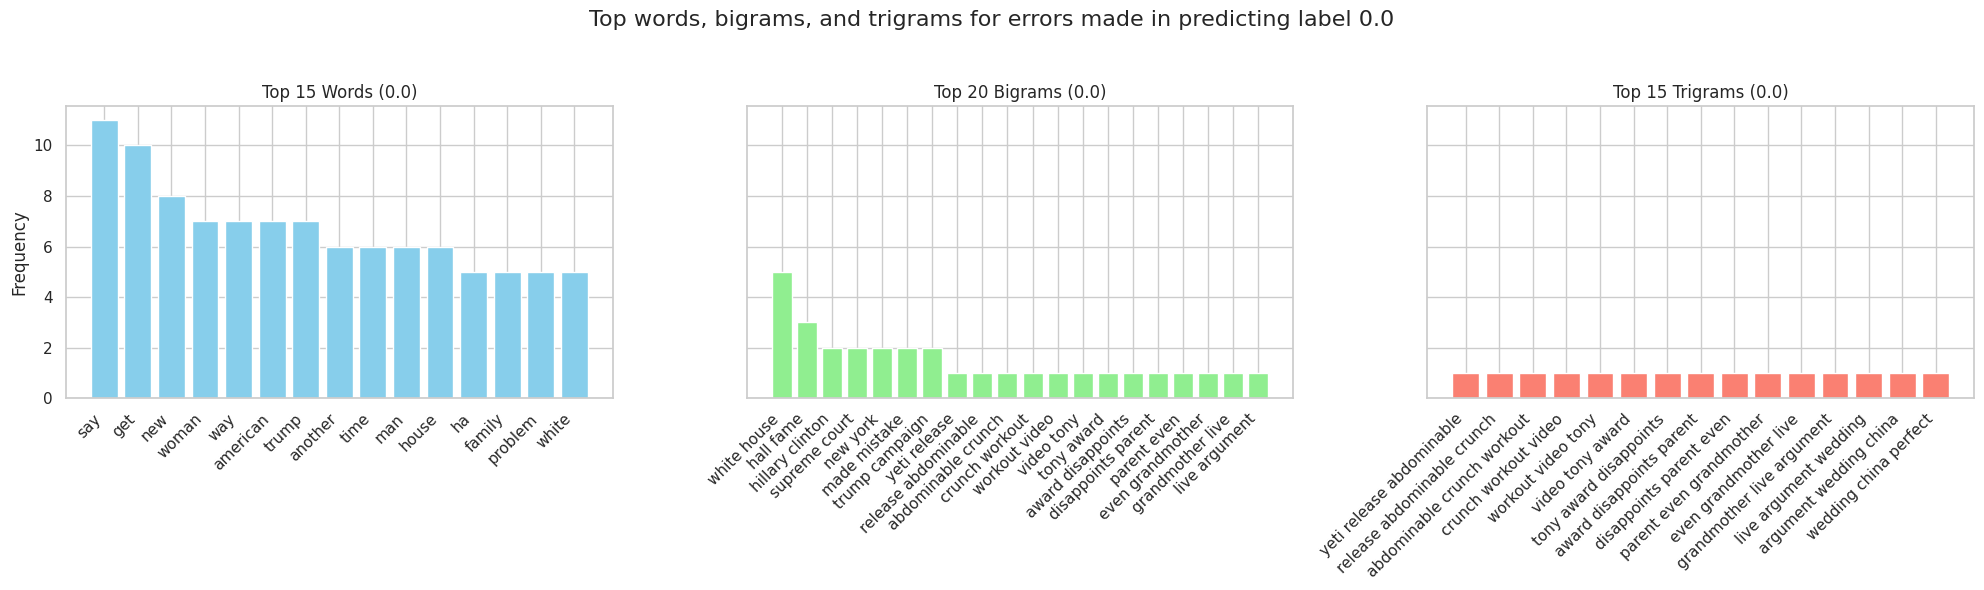

In [ ]:
stop_words = list(set(stopwords.words('english')))
label_ngram_counts = get_top_ngrams_by_label(two_layers_error_df, text_column='headline', label_column='predicted_label', stop_words=stop_words)
plot_top_ngrams(label_ngram_counts)

## **OOV DISTRIBUTION**
Below, I analyzed whether the presence of OOV words could have been an obstacle for the BiLSTM models. However, as expected, it did not prove to be a particularly challenging issue, given their limited presence in both the validation and test sets.

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import string

def has_oov_tokens(headline, vocab):
    """Checks if a headline contains any OOV tokens and counts them."""
    # Tokenize and clean the headline
    words = headline.split()
    oov_count = 0

    for word in words:
        # Convert to lowercase and remove punctuation
        clean_word = word.lower().strip(string.punctuation)
        if clean_word not in vocab and clean_word != "<pad>":
            oov_count += 1

    has_oov = oov_count > 0
    return has_oov, oov_count

def analyze_oov_distribution(model_error_df, vocab):
    """Analyzes the distribution of OOV tokens in a dataset and plots it."""
    errors_with_oov = 0
    oov_counts = []

    for _, row in model_error_df.iterrows():
        headline = row['headline']
        has_oov, oov_count = has_oov_tokens(headline, vocab)
        if has_oov:
            errors_with_oov += 1
        oov_counts.append(oov_count)

    # Calculate and display statistics
    percentage_with_oov = (errors_with_oov / len(model_error_df)) * 100
    print(f"Percentage of sentences with OOV tokens: {percentage_with_oov:.2f}%")

    # Distribution of OOV counts
    oov_count_distribution = Counter(oov_counts)
    total_sentences = len(model_error_df)

    print("\nPercentage of sentences for each number of OOV tokens:")
    for oov_count, freq in sorted(oov_count_distribution.items()):
        percentage = (freq / total_sentences) * 100
        print(f"{oov_count} OOV token(s): {percentage:.2f}%")

    # Plot distribution
    plt.hist(oov_counts, bins=range(0, max(oov_counts) + 2), edgecolor='black')
    plt.title("Distribution of OOV Tokens in Headlines")
    plt.xlabel("Number of OOV Tokens")
    plt.ylabel("Frequency")
    plt.show()

In [ ]:
correctly_classified_headlines = []
for row, predicted_label in zip(test_df_embedded.itertuples(), predicted_one_layer):
    if row.label == predicted_label:
        correctly_classified_headlines.append({
            'headline': row.headline,
            'original_label': row.label,
            'predicted_label': predicted_label
        })

correctly_classified_df = pd.DataFrame(correctly_classified_headlines)

- OOV over the test set

Percentage of sentences with OOV tokens: 43.35%

Percentage of sentences for each number of OOV tokens:
0 OOV token(s): 56.65%
1 OOV token(s): 30.59%
2 OOV token(s): 10.30%
3 OOV token(s): 2.06%
4 OOV token(s): 0.41%


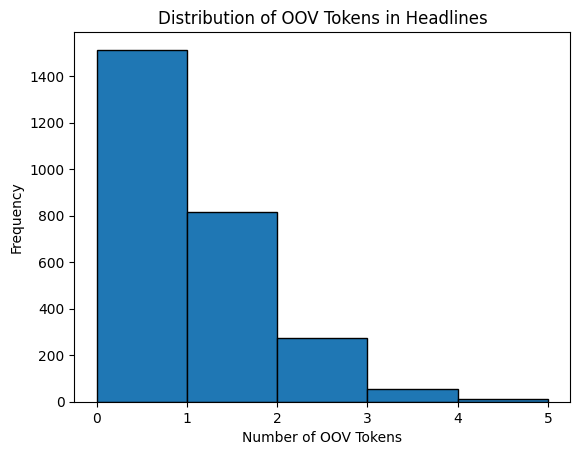

In [ ]:
analyze_oov_distribution(test_df, vocab)

- OOV over the wrong predictions (1 Layer BiLSTM)

Percentage of sentences with OOV tokens: 45.86%

Percentage of sentences for each number of OOV tokens:
0 OOV token(s): 54.14%
1 OOV token(s): 31.75%
2 OOV token(s): 10.23%
3 OOV token(s): 3.53%
4 OOV token(s): 0.35%


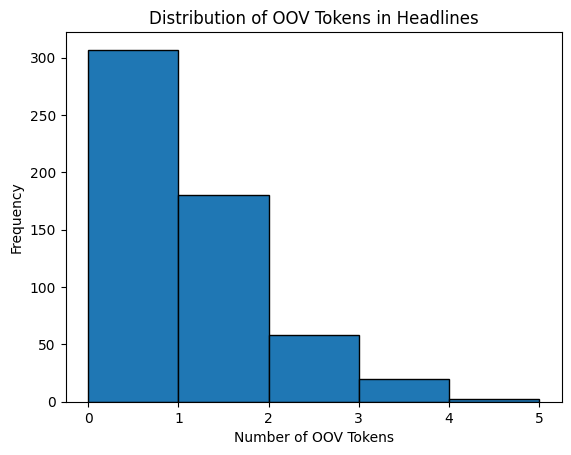

In [ ]:
analyze_oov_distribution(one_layer_error_df, vocab)

- OOV over the correct predicitons (1 Layer BiLSTM)

Percentage of sentences with OOV tokens: 42.68%

Percentage of sentences for each number of OOV tokens:
0 OOV token(s): 57.32%
1 OOV token(s): 30.28%
2 OOV token(s): 10.31%
3 OOV token(s): 1.66%
4 OOV token(s): 0.43%


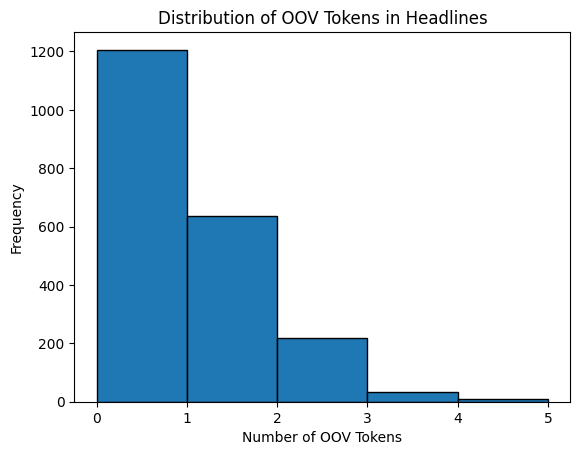

In [ ]:
analyze_oov_distribution(correctly_classified_df, vocab)

## **EMBEDDING SIZE INCREASED (from 100 to 300)**
Here, I repeated the same training and testing on the models used previously, aiming to see if using embeddings of a larger dimension could improve performance by allowing the processing of richer informational content. From the results obtained, it seems that the limitation is not so much due to a lack of informational content, but rather to the way RNNs process and learn from the sequences provided as input. However, there is still a minimal improvement, suggesting that adding informational content can allow the model to achieve slightly better results, even though it cannot be said that this is the best strategy for achieving significant improvements on this type of task.

In [ ]:
embedding_dim = 300
glove_filepath = os.path.join(extract_path, f'glove.6B.{embedding_dim}d.txt')
glove_embeddings = load_glove_embeddings(glove_filepath, embedding_dim)
print("Loaded GloVe embeddings with dimension:", embedding_dim)

Loaded GloVe embeddings with dimension: 300


In [ ]:
train_df = original_train_df.copy()
validation_df = original_validation_df.copy()
test_df = original_test_df.copy()

In [ ]:
train_df['headline'] = train_df['headline'].apply(clean_headline_rnn)
validation_df['headline'] = validation_df['headline'].apply(clean_headline_rnn)
test_df['headline'] = test_df['headline'].apply(clean_headline_rnn)

In [ ]:
train_df['padded_headline'] = pad_headlines(train_df, 'headline')
validation_df['padded_headline'] = pad_headlines(validation_df, 'headline')
test_df['padded_headline'] = pad_headlines(test_df, 'headline')
print('first padded healine:')
print(train_df['padded_headline'][0])
vocab, word_embeddings = build_vocab_and_embeddings_char(train_df, glove_embeddings, embedding_dim)
unk_token = '[UNK]'
vocab[unk_token] = len(vocab)
unk_embedding = np.mean(word_embeddings, axis=0)
word_embeddings = np.vstack([word_embeddings, unk_embedding])

max len: =39
max len: =24
max len: =22
first padded healine:
['former', 'versace', 'store', 'clerk', 'sue', 'over', 'secret', 'black', 'code', 'for', 'minority', 'shopper', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


In [ ]:
train_df_embedded = embed_headline(train_df, vocab, word_embeddings)
validation_df_embedded = embed_headline(validation_df, vocab, word_embeddings)
test_df_embedded = embed_headline(test_df, vocab, word_embeddings)
print(len(train_df_embedded['embed_headline'][0][0]))

300


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_train = torch.tensor(np.array(train_df_embedded['embed_headline'].tolist()), dtype=torch.float32).to(device)
y_train = torch.tensor(train_df_embedded['label'].values, dtype=torch.float32).to(device)
x_val = torch.tensor(np.array(validation_df_embedded['embed_headline'].tolist()), dtype=torch.float32).to(device)
y_val = torch.tensor(validation_df_embedded['label'].values, dtype=torch.float32).to(device)
x_test = torch.tensor(np.array(test_df_embedded['embed_headline'].tolist()), dtype=torch.float32).to(device)
y_test = torch.tensor(test_df_embedded['label'].values, dtype=torch.float32).to(device)

- BiRNN 1 Layer training


Training with seed 5
Layer                                    Parameters     
rnn.weight_ih_l0                         9600           
rnn.weight_hh_l0                         1024           
rnn.bias_ih_l0                           32             
rnn.bias_hh_l0                           32             
rnn.weight_ih_l0_reverse                 9600           
rnn.weight_hh_l0_reverse                 1024           
rnn.bias_ih_l0_reverse                   32             
rnn.bias_hh_l0_reverse                   32             
fc.weight                                64             
fc.bias                                  1              
Total Trainable Parameters: 21441
Early stopping at epoch 38.
Best Val F1: 0.8148.


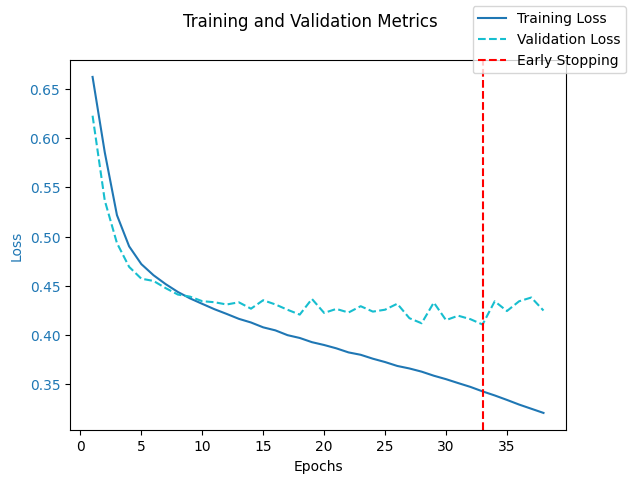


Training with seed 20
Early stopping at epoch 21.
Best Val F1: 0.8007.


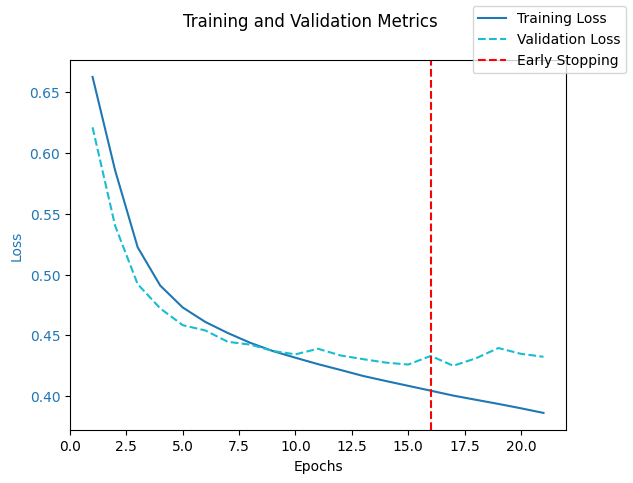


Training with seed 38
Early stopping at epoch 19.
Best Val F1: 0.8006.


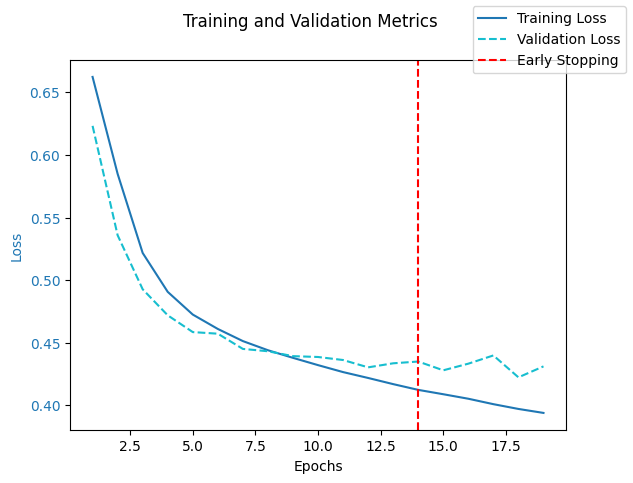


Training with seed 42
Early stopping at epoch 31.
Best Val F1: 0.8094.


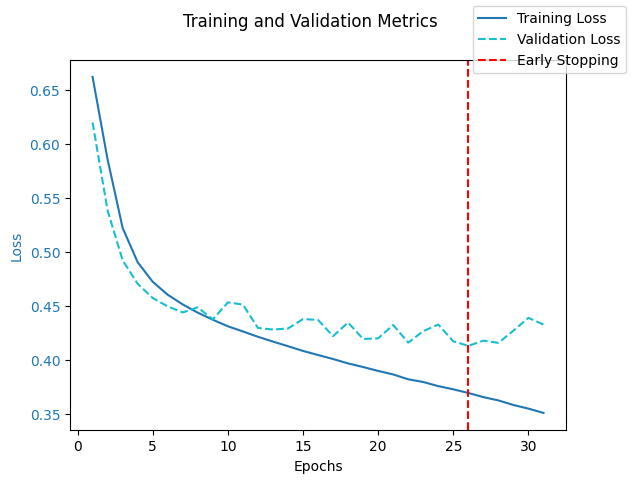


Training with seed 60
Early stopping at epoch 39.
Best Val F1: 0.8166.


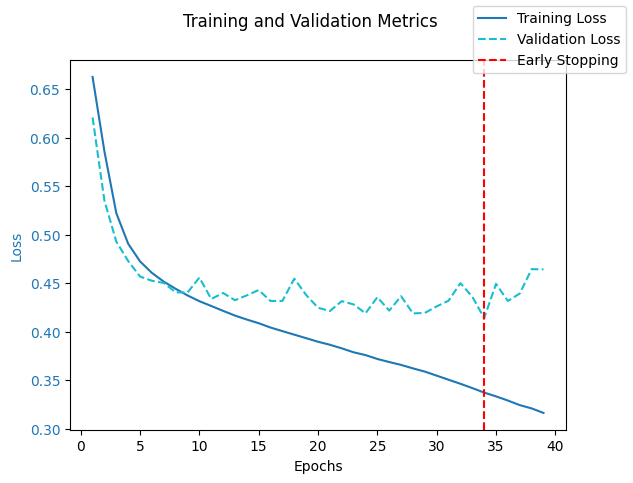

In [ ]:
hidden_size = 32
num_layers = 1
input_size = 300
output_size = 1
models_one_layer_rnn = []
main_training_rnn(x_train, y_train, x_val, y_val, input_size, hidden_size, num_layers, output_size, models_one_layer_rnn, learning_rate, num_epochs, batch_size)

- BiLSTM 1 layer training


Training with seed 5
Layer                                    Parameters     
lstm.weight_ih_l0                        38400          
lstm.weight_hh_l0                        4096           
lstm.bias_ih_l0                          128            
lstm.bias_hh_l0                          128            
lstm.weight_ih_l0_reverse                38400          
lstm.weight_hh_l0_reverse                4096           
lstm.bias_ih_l0_reverse                  128            
lstm.bias_hh_l0_reverse                  128            
fc.weight                                64             
fc.bias                                  1              
Total Trainable Parameters: 85569
Early stopping at epoch 19.
Best Val F1: 0.8362.


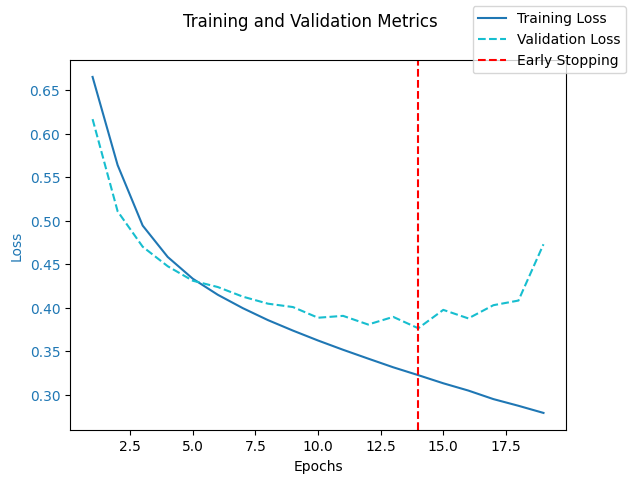


Training with seed 20
Early stopping at epoch 19.
Best Val F1: 0.8303.


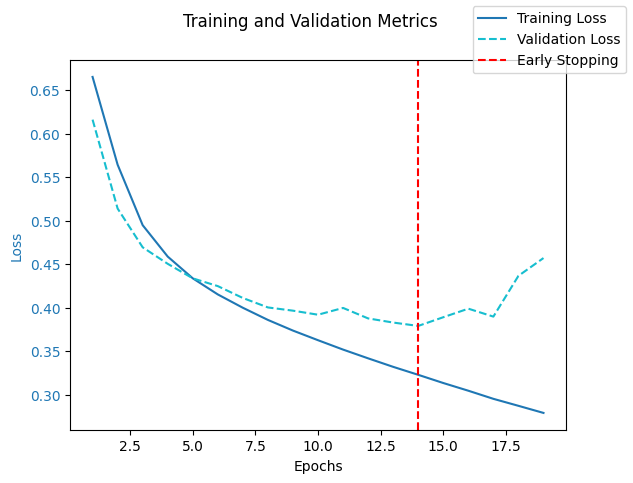


Training with seed 38
Early stopping at epoch 20.
Best Val F1: 0.8325.


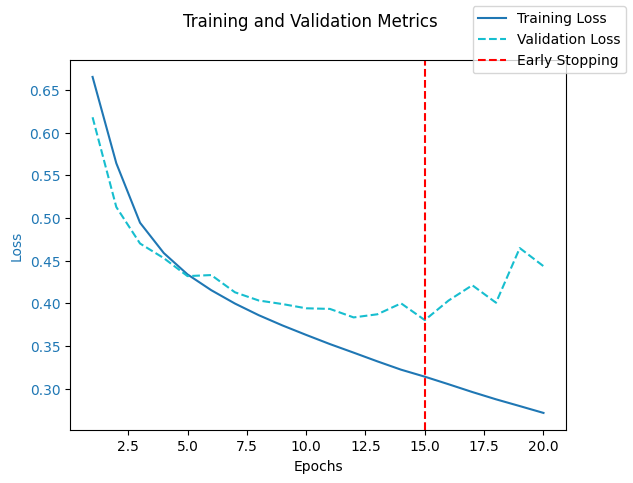


Training with seed 42
Early stopping at epoch 18.
Best Val F1: 0.8350.


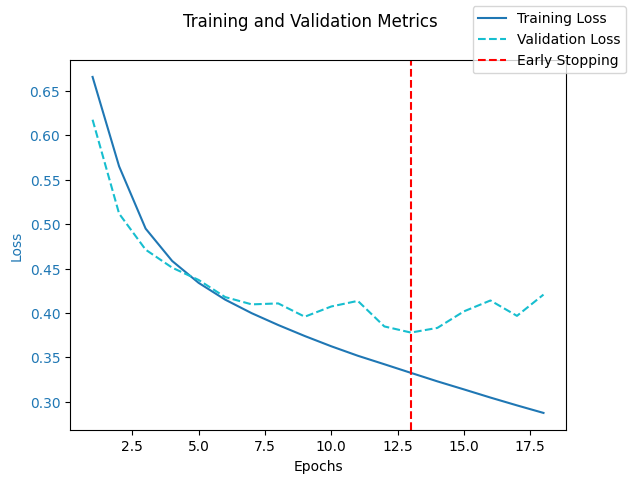


Training with seed 60
Early stopping at epoch 16.
Best Val F1: 0.8282.


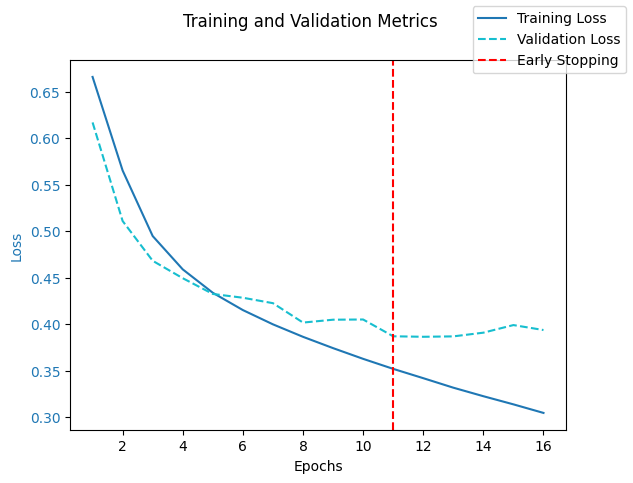

In [ ]:
models_one_layer_lstm = []
main_training_lstm(x_train, y_train, x_val, y_val, input_size, hidden_size, num_layers, output_size, models_one_layer_lstm , learning_rate, num_epochs, batch_size)

- BiRNN 1 Layer evaluation

In [ ]:
evaluate_models(models_one_layer_rnn, x_test, y_test, batch_size=128, device=device)

Model 1:
  Test Accuracy: 0.7963
  Test F1 Score: 0.7960

Model 2:
  Test Accuracy: 0.7851
  Test F1 Score: 0.7845

Model 3:
  Test Accuracy: 0.7844
  Test F1 Score: 0.7835

Model 4:
  Test Accuracy: 0.7926
  Test F1 Score: 0.7924

Model 5:
  Test Accuracy: 0.7873
  Test F1 Score: 0.7873

Average Accuracy: 0.7891
Average F1 Score: 0.7888



- BiLSTM 1 Layer evaluation

In [ ]:
evaluate_models(models_one_layer_lstm, x_test, y_test, batch_size=128, device=device)

Model 1:
  Test Accuracy: 0.7948
  Test F1 Score: 0.7947

Model 2:
  Test Accuracy: 0.8046
  Test F1 Score: 0.8045

Model 3:
  Test Accuracy: 0.8072
  Test F1 Score: 0.8072

Model 4:
  Test Accuracy: 0.8165
  Test F1 Score: 0.8165

Model 5:
  Test Accuracy: 0.8207
  Test F1 Score: 0.8204

Average Accuracy: 0.8088
Average F1 Score: 0.8086



- BiRNN 2 Layer training


Training with seed 5
Layer                                    Parameters     
rnn.weight_ih_l0                         9600           
rnn.weight_hh_l0                         1024           
rnn.bias_ih_l0                           32             
rnn.bias_hh_l0                           32             
rnn.weight_ih_l0_reverse                 9600           
rnn.weight_hh_l0_reverse                 1024           
rnn.bias_ih_l0_reverse                   32             
rnn.bias_hh_l0_reverse                   32             
rnn.weight_ih_l1                         2048           
rnn.weight_hh_l1                         1024           
rnn.bias_ih_l1                           32             
rnn.bias_hh_l1                           32             
rnn.weight_ih_l1_reverse                 2048           
rnn.weight_hh_l1_reverse                 1024           
rnn.bias_ih_l1_reverse                   32             
rnn.bias_hh_l1_reverse                   32             
fc.weight

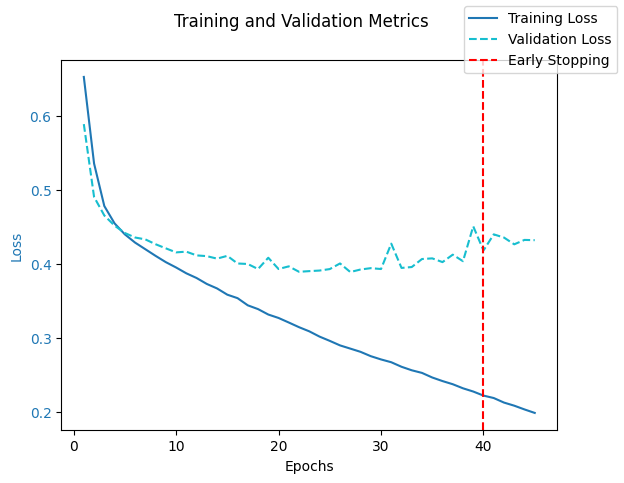


Training with seed 20
Early stopping at epoch 22.
Best Val F1: 0.8230.


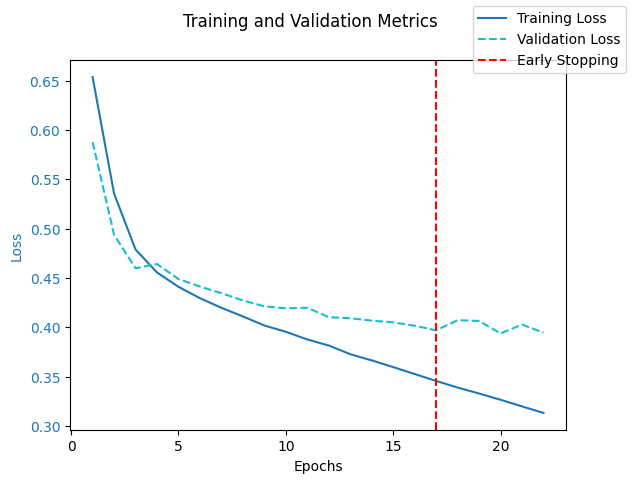


Training with seed 38
Early stopping at epoch 42.
Best Val F1: 0.8337.


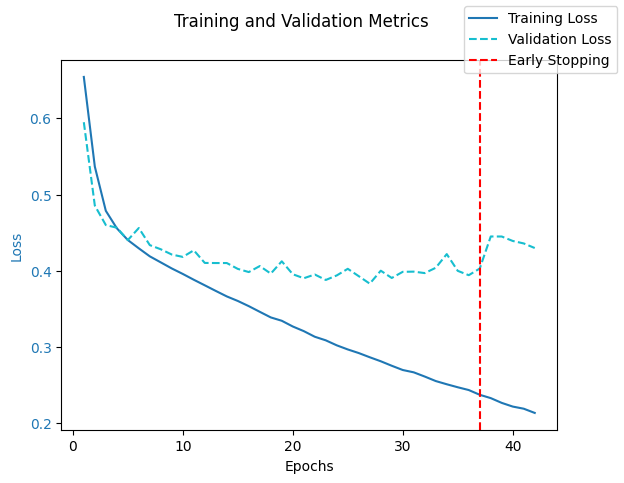


Training with seed 42
Early stopping at epoch 38.
Best Val F1: 0.8355.


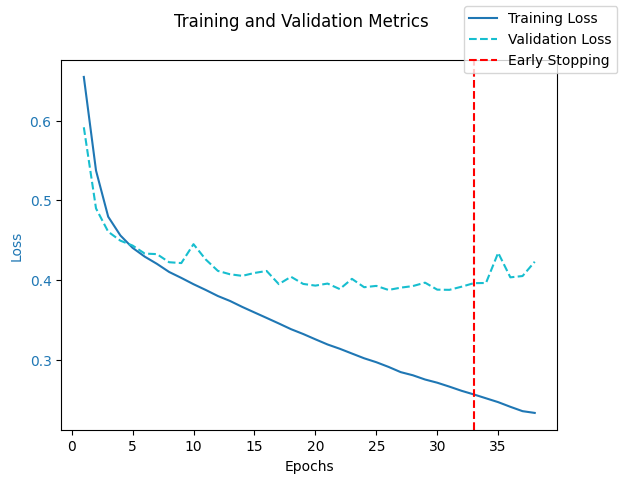


Training with seed 60
Early stopping at epoch 39.
Best Val F1: 0.8330.


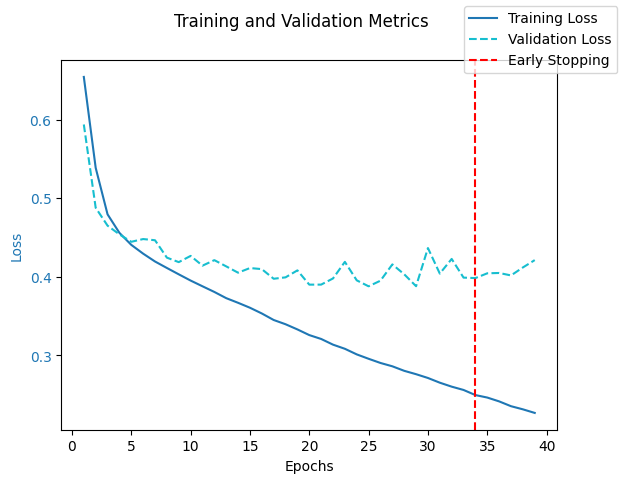

In [ ]:
hidden_size = 32
num_layers = 2
input_size = 300
output_size = 1
models_2l_rnn = []
main_training_rnn(x_train, y_train, x_val, y_val, input_size, hidden_size, num_layers, output_size, models_2l_rnn, learning_rate,num_epochs,batch_size)

- BiLSTM 2 Layers training


Training with seed 5
Layer                                    Parameters     
lstm.weight_ih_l0                        38400          
lstm.weight_hh_l0                        4096           
lstm.bias_ih_l0                          128            
lstm.bias_hh_l0                          128            
lstm.weight_ih_l0_reverse                38400          
lstm.weight_hh_l0_reverse                4096           
lstm.bias_ih_l0_reverse                  128            
lstm.bias_hh_l0_reverse                  128            
lstm.weight_ih_l1                        8192           
lstm.weight_hh_l1                        4096           
lstm.bias_ih_l1                          128            
lstm.bias_hh_l1                          128            
lstm.weight_ih_l1_reverse                8192           
lstm.weight_hh_l1_reverse                4096           
lstm.bias_ih_l1_reverse                  128            
lstm.bias_hh_l1_reverse                  128            
fc.weight

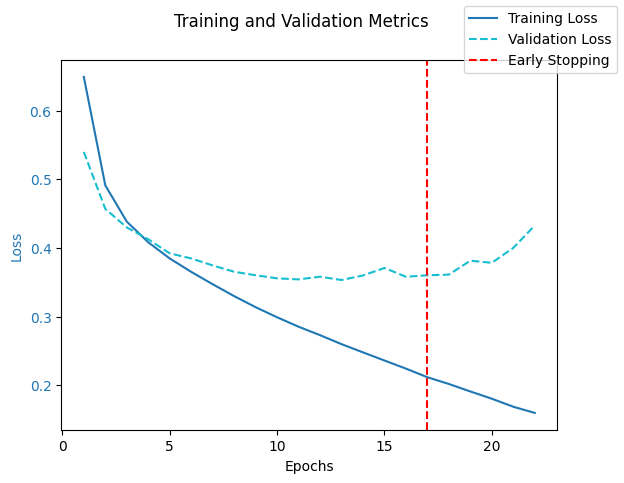


Training with seed 20
Early stopping at epoch 20.
Best Val F1: 0.8514.


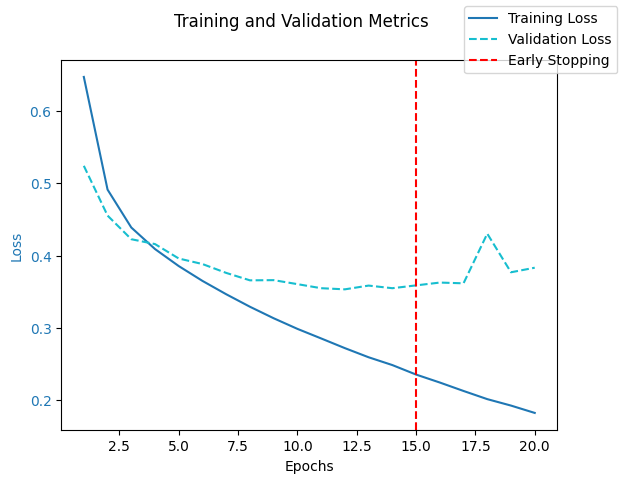


Training with seed 38
Early stopping at epoch 21.
Best Val F1: 0.8513.


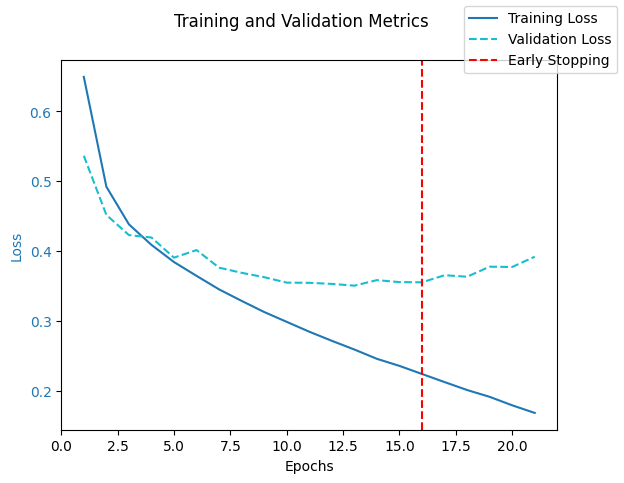


Training with seed 42
Early stopping at epoch 19.
Best Val F1: 0.8528.


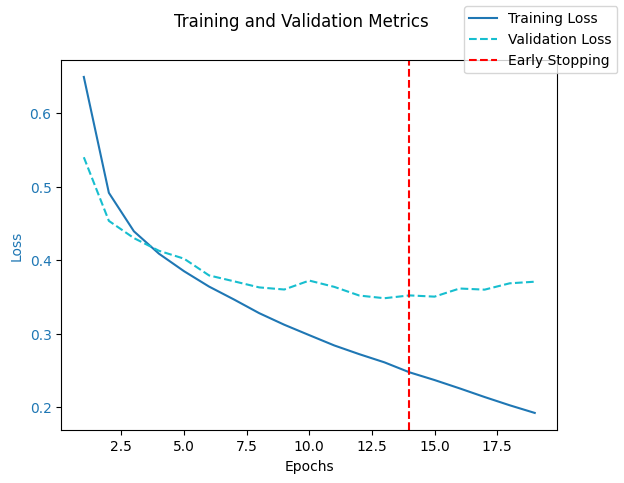


Training with seed 60
Early stopping at epoch 19.
Best Val F1: 0.8512.


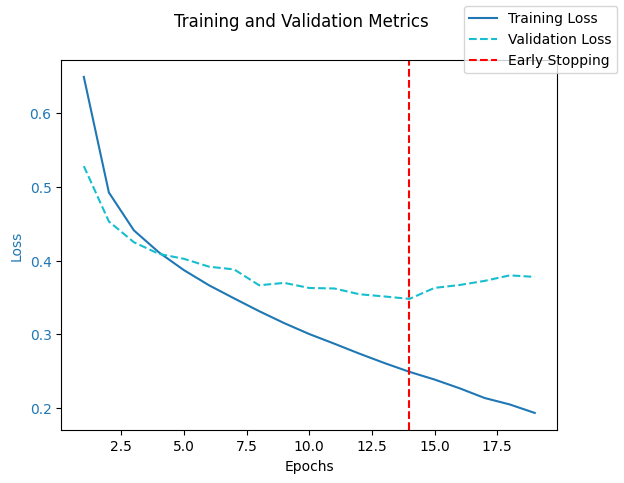

In [ ]:
models_2l_lstm = []
main_training_lstm(x_train, y_train, x_val, y_val, input_size, hidden_size, num_layers, output_size, models_2l_lstm, learning_rate,num_epochs,batch_size)

- BiRNN 2 Layers evaluation

In [ ]:
evaluate_models(models_2l_rnn, x_test, y_test, batch_size=128, device=device)

Model 1:
  Test Accuracy: 0.8293
  Test F1 Score: 0.8271

Model 2:
  Test Accuracy: 0.8139
  Test F1 Score: 0.8121

Model 3:
  Test Accuracy: 0.8304
  Test F1 Score: 0.8289

Model 4:
  Test Accuracy: 0.8278
  Test F1 Score: 0.8268

Model 5:
  Test Accuracy: 0.8244
  Test F1 Score: 0.8231

Average Accuracy: 0.8252
Average F1 Score: 0.8236



- BiLSTM 2 Layers evaluation

In [ ]:
evaluate_models(models_2l_lstm, x_test, y_test, batch_size=128, device=device)

Model 1:
  Test Accuracy: 0.8480
  Test F1 Score: 0.8473

Model 2:
  Test Accuracy: 0.8506
  Test F1 Score: 0.8494

Model 3:
  Test Accuracy: 0.8559
  Test F1 Score: 0.8543

Model 4:
  Test Accuracy: 0.8551
  Test F1 Score: 0.8526

Model 5:
  Test Accuracy: 0.8502
  Test F1 Score: 0.8490

Average Accuracy: 0.8520
Average F1 Score: 0.8505



## **EMBEDDINGS GENERATED USING BERT MODEL**<br>
Finally, I tried iterating the training of the RNN and LSTM models using the embeddings generated with the same encoder model used previously, to see if generating embeddings directly by examining the current training set could be effective. The results are very similar to those obtained with GloVe embeddings, with a minimal improvement observed for the results obtained with the 1-layer models. This confirms what was previously noted, namely that the most evident limitation of these models compared to the transformer model is their relatively limited processing capacity.

In [ ]:
train_df = original_train_df.copy()
validation_df = original_validation_df.copy()
test_df = original_test_df.copy()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transformer_model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(transformer_model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(transformer_model_name)
model = model.to(device)

In [ ]:
train_df = original_train_df.copy()
validation_df = original_validation_df.copy()
test_df = original_test_df.copy()

train_df['headline'] = train_df['headline'].apply(clean_headline_rnn)
validation_df['headline'] = validation_df['headline'].apply(clean_headline_rnn)
test_df['headline'] = test_df['headline'].apply(clean_headline_rnn)

train_df['padded_headline'] = pad_headlines(train_df, 'headline')
validation_df['padded_headline'] = pad_headlines(validation_df, 'headline')
test_df['padded_headline'] = pad_headlines(test_df, 'headline')

max len: =39
max len: =24
max len: =22


## Vocabulary Generation
The vocabulary in this case is built in the same way as it was defined in the case of GloVe embeddings. The key difference is that the embeddings available now are generated by the transformer. The embeddings are generated by tokenizing each sentence of the corpus, passing the tokens through the transformer model to obtain its hidden states. The embeddings are extracted by averaging the states of the last 4 layers and aggregating the embeddings of the sub-tokens for each word. Finally, each word is associated with its average embedding, considering only the first occurrence of each word.

In [ ]:
from tqdm import tqdm

def generate_token_embeddings(model, tokenizer, corpus, max_seq_length=128, layers_to_consider=None):
    # Switch the model to evaluation mode
    model.eval()
    model.to(device)
    embeddings = {}

    # Default layers to consider if none are provided (last 4 layers)
    if layers_to_consider is None:
        layers_to_consider = [-4, -3, -2, -1]

    def get_word_embeddings(sentence, layers_to_consider):
        # Tokenize the input sentence and prepare it for the model
        inputs = tokenizer(sentence, return_tensors="pt", truncation=True, max_length=max_seq_length, return_offsets_mapping=True)
        inputs = {key: value.to(device) for key, value in inputs.items()}
        offsets = inputs.pop("offset_mapping")[0].cpu().numpy()  # Mapping between token and original characters

        # Run the model in inference mode
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)

        hidden_states = outputs.hidden_states

        # Average of the selected layers' token embeddings
        token_embeddings = torch.stack([hidden_states[layer] for layer in layers_to_consider], dim=0).mean(dim=0)

        # Convert token IDs to actual tokens
        input_ids = inputs["input_ids"].cpu().numpy()[0]
        tokens = tokenizer.convert_ids_to_tokens(input_ids)

        word_embeddings = {}
        current_word = ""
        current_embedding = []

        # Loop through the tokens and aggregate the embeddings for each word
        for idx, token in enumerate(tokens):
            if token in ["[CLS]", "[SEP]", "[PAD]"]:  # Ignore special tokens
                continue

            if token.startswith("##"):  # Handle WordPiece/BPE sub-tokens
                current_word += token[2:]
            else:
                # If a word has accumulated, store its embedding (average of sub-token embeddings)
                if current_word:
                    word_embeddings[current_word] = np.mean(current_embedding, axis=0)
                current_word = token
                current_embedding = []

            current_embedding.append(token_embeddings[0, idx].cpu().numpy())

        # Add the last word's embedding to the dictionary
        if current_word and current_word not in word_embeddings:
            word_embeddings[current_word] = np.mean(current_embedding, axis=0)

        return word_embeddings

    # Iterate over the entire corpus and collect embeddings for each unique word
    for sentence in tqdm(corpus, desc="Generating token embeddings"):
        sentence_embeddings = get_word_embeddings(sentence, layers_to_consider)
        for word, embedding in sentence_embeddings.items():
            if word not in embeddings:
                embeddings[word] = embedding  # Use the first occurrence of the word

    return embeddings

def build_vocab_and_embeddings_char(data, embeddings_index, embedding_dim):
    """Build vocabulary and embeddings using character-level embeddings."""
    vocab = {}
    word_embeddings = []

    def get_word_embedding_from_chars(token):
        # Generate embeddings for a word based on its characters
        char_embeddings = []
        for char in token:
            if char in embeddings_index:
                char_embeddings.append(embeddings_index[char])
            else:
                # Assign a random embedding for unknown characters
                char_embeddings.append(np.random.uniform(np.min(average_vector), np.max(average_vector), embedding_dim))
        # Compute the average of character embeddings to represent the word
        return np.mean(char_embeddings, axis=0)

    # Iterate over all padded headlines in the dataset
    for headline in tqdm(data['padded_headline'], desc="Building vocabulary"):
        for token in headline:
            # Check if the token is already in the vocabulary
            if token not in vocab:
                if token in embeddings_index:
                    # If the token exists in the pre-trained embeddings, use its embedding
                    vocab[token] = len(vocab)
                    word_embeddings.append(embeddings_index[token])
                elif token == "<PAD>":
                    # Assign an embedding of zeros for the padding token
                    vocab[token] = len(vocab)
                    word_embeddings.append(np.zeros(embedding_dim))
                else:
                    # Compute the word embedding using character-level embeddings
                    word_embedding = get_word_embedding_from_chars(token)
                    vocab[token] = len(vocab)
                    word_embeddings.append(word_embedding)

    return vocab, np.array(word_embeddings)

Given that BERT produces embeddings of size 768, I chose to apply PCA to reduce the dimensionality to 300, ensuring a more consistent comparison with GloVe embeddings.

In [ ]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Set the device to GPU if available, otherwise use CPU
corpus = train_df['headline']  # Extract the headlines from the training dataframe

from sklearn.decomposition import PCA

def reduce_embedding_dimensionality(embeddings, target_dim=300):
    """Reduce embeddings from 768 to target_dim using PCA."""
    all_embeddings = np.array(list(embeddings.values()))
    # Apply PCA to reduce dimensionality to target_dim (default 300)
    pca = PCA(n_components=target_dim)
    reduced_embeddings = pca.fit_transform(all_embeddings)
    reduced_dict = {word: reduced_embeddings[idx] for idx, word in enumerate(embeddings.keys())}
    return reduced_dict

In [ ]:
# Generate token embeddings using the transformer model
transformer_embeddings = generate_token_embeddings(
    model=model,
    tokenizer=tokenizer,
    corpus=corpus,
    max_seq_length=128,
    layers_to_consider=[-4, -3, -2, -1]
)

# Dimensionality reduction of embeddings from 768 to 300 using PCA
reduced_embeddings = reduce_embedding_dimensionality(transformer_embeddings, target_dim=300)
embedding_dim = 300
average_vector = np.mean(np.array(list(reduced_embeddings.values())), axis=0)  # Compute the mean vector for setting the bounds for unknown characters

# Build the vocabulary and embeddings
vocab, embeddings = build_vocab_and_embeddings_char(
    train_df,
    reduced_embeddings,
    embedding_dim
)


Building vocabulary: 100%|██████████| 16414/16414 [00:00<00:00, 227927.61it/s]


In [ ]:
unk_token = '[UNK]'
vocab[unk_token] = len(vocab)
unk_embedding = np.mean(embeddings, axis=0)
word_embeddings = np.vstack([embeddings, unk_embedding])

In [ ]:
print("Vocab size:", len(vocab))
print("Embeddings shape:", embeddings.shape)

Vocab size: 19852
Embeddings shape: (19851, 300)


In [ ]:
"""
train_df['padded_headline'] = pad_headlines(train_df, 'headline')
validation_df['padded_headline'] = pad_headlines(validation_df, 'headline')
test_df['padded_headline'] = pad_headlines(test_df, 'headline')
"""

max len: =39
max len: =24
max len: =22


In [ ]:
train_df_embedded = embed_headline(train_df, vocab, word_embeddings)
validation_df_embedded = embed_headline(validation_df, vocab, word_embeddings)
test_df_embedded = embed_headline(test_df, vocab, word_embeddings)
print(len(train_df_embedded['embed_headline'][0][0]))

300


In [ ]:
oov_train, total_train, oov_percentage_train = calculate_oov_percentage(train_df, vocab)
oov_validation, total_validation, oov_percentage_validation = calculate_oov_percentage(validation_df, vocab)
oov_test, total_test, oov_percentage_test = calculate_oov_percentage(test_df, vocab)
print(f"Train set: {oov_train}/{total_train} OOV tokens ({oov_percentage_train:.2f}%)")
print(f"Validation set: {oov_validation}/{total_validation} OOV tokens ({oov_percentage_validation:.2f}%)")
print(f"Test set: {oov_test}/{total_test} OOV tokens ({oov_percentage_test:.2f}%)")

Train set: 0/640146 OOV tokens (0.00%)
Validation set: 3140/128208 OOV tokens (2.45%)
Test set: 1576/58762 OOV tokens (2.68%)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_train = torch.tensor(np.array(train_df_embedded['embed_headline'].tolist()), dtype=torch.float32).to(device)
y_train = torch.tensor(train_df_embedded['label'].values, dtype=torch.float32).to(device)
x_val = torch.tensor(np.array(validation_df_embedded['embed_headline'].tolist()), dtype=torch.float32).to(device)
y_val = torch.tensor(validation_df_embedded['label'].values, dtype=torch.float32).to(device)
x_test = torch.tensor(np.array(test_df_embedded['embed_headline'].tolist()), dtype=torch.float32).to(device)
y_test = torch.tensor(test_df_embedded['label'].values, dtype=torch.float32).to(device)

- BiRNN 1 layer training


Training with seed 5
Layer                                    Parameters     
rnn.weight_ih_l0                         9600           
rnn.weight_hh_l0                         1024           
rnn.bias_ih_l0                           32             
rnn.bias_hh_l0                           32             
rnn.weight_ih_l0_reverse                 9600           
rnn.weight_hh_l0_reverse                 1024           
rnn.bias_ih_l0_reverse                   32             
rnn.bias_hh_l0_reverse                   32             
fc.weight                                64             
fc.bias                                  1              
Total Trainable Parameters: 21441
Early stopping at epoch 23.
Best Val F1: 0.8255.


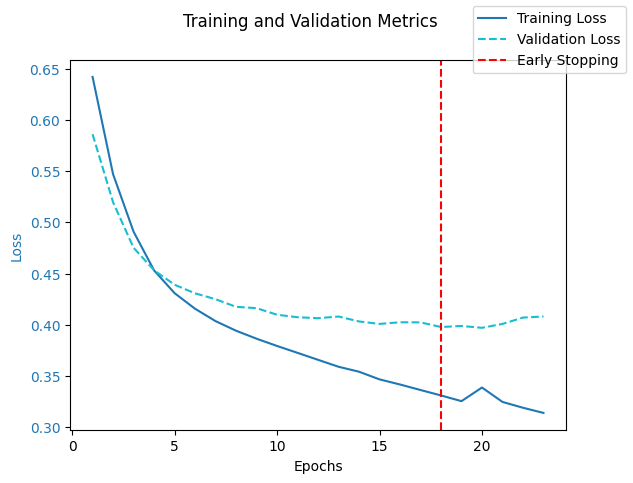


Training with seed 20
Early stopping at epoch 19.
Best Val F1: 0.8270.


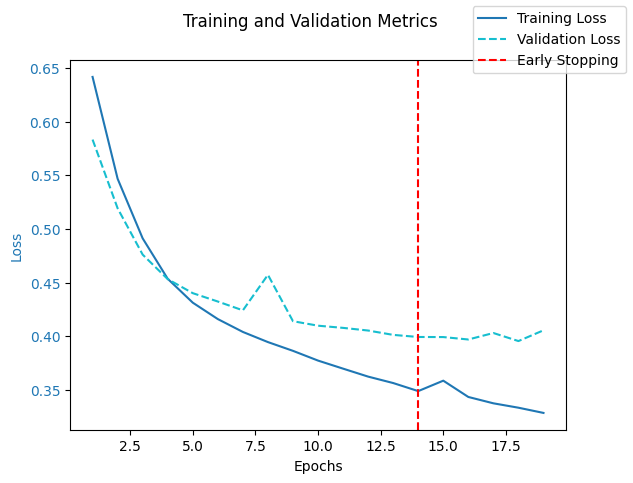


Training with seed 38
Early stopping at epoch 22.
Best Val F1: 0.8257.


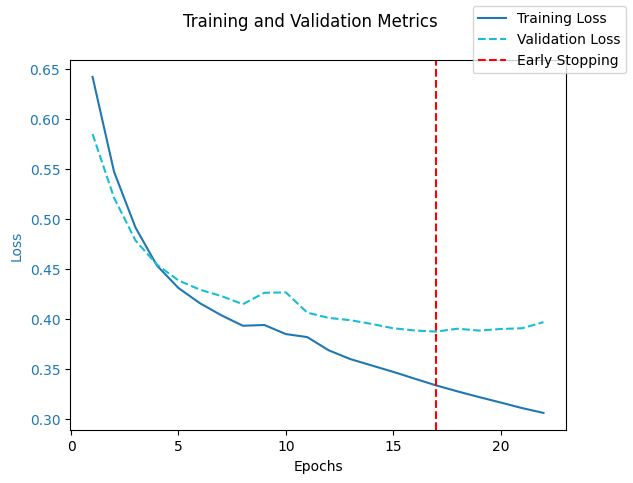


Training with seed 42
Early stopping at epoch 23.
Best Val F1: 0.8276.


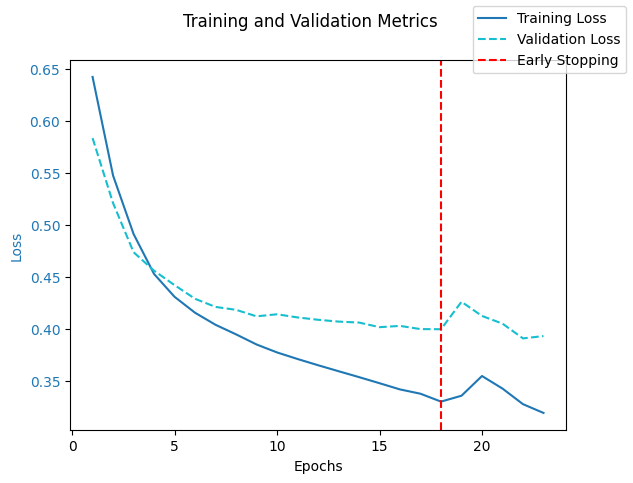


Training with seed 60
Early stopping at epoch 18.
Best Val F1: 0.8223.


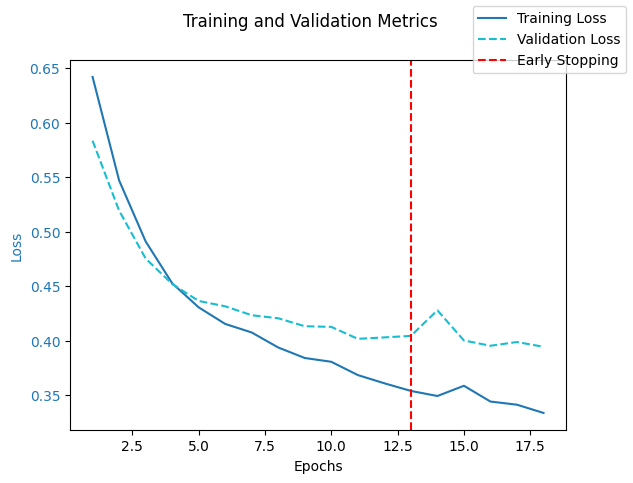

In [ ]:
hidden_size = 32
learning_rate = 0.00005
num_layers = 1
input_size = 300
output_size = 1
models_one_layer_rnn = []
main_training_rnn(x_train, y_train, x_val, y_val, input_size, hidden_size, num_layers, output_size, models_one_layer_rnn, learning_rate, num_epochs, batch_size)

- BiLSTM 1 layer training


Training with seed 5
Layer                                    Parameters     
lstm.weight_ih_l0                        38400          
lstm.weight_hh_l0                        4096           
lstm.bias_ih_l0                          128            
lstm.bias_hh_l0                          128            
lstm.weight_ih_l0_reverse                38400          
lstm.weight_hh_l0_reverse                4096           
lstm.bias_ih_l0_reverse                  128            
lstm.bias_hh_l0_reverse                  128            
fc.weight                                64             
fc.bias                                  1              
Total Trainable Parameters: 85569
Early stopping at epoch 18.
Best Val F1: 0.8450.


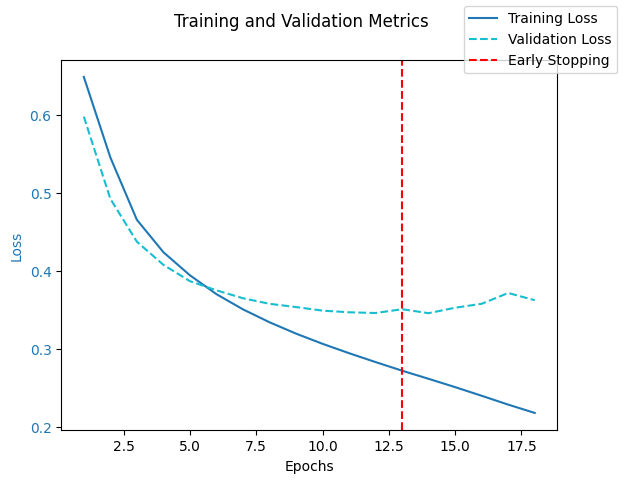


Training with seed 20
Early stopping at epoch 18.
Best Val F1: 0.8443.


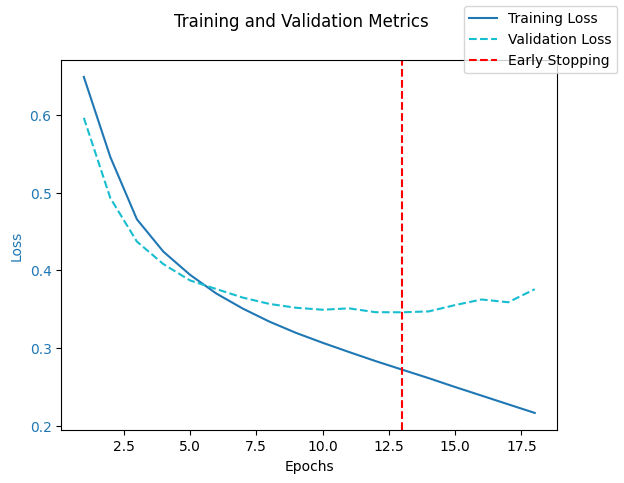


Training with seed 38
Early stopping at epoch 23.
Best Val F1: 0.8465.


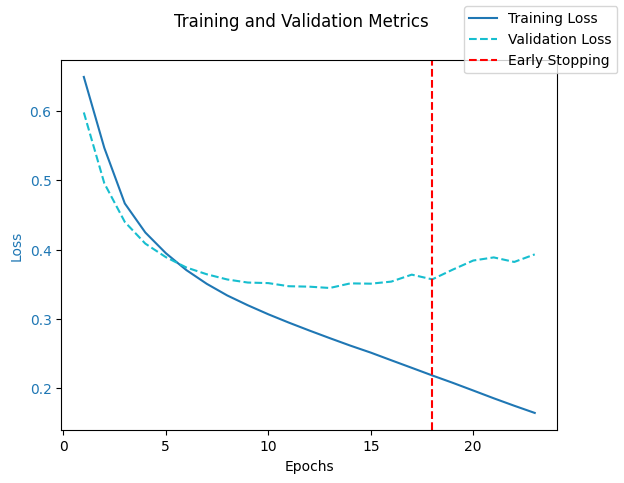


Training with seed 42
Early stopping at epoch 18.
Best Val F1: 0.8459.


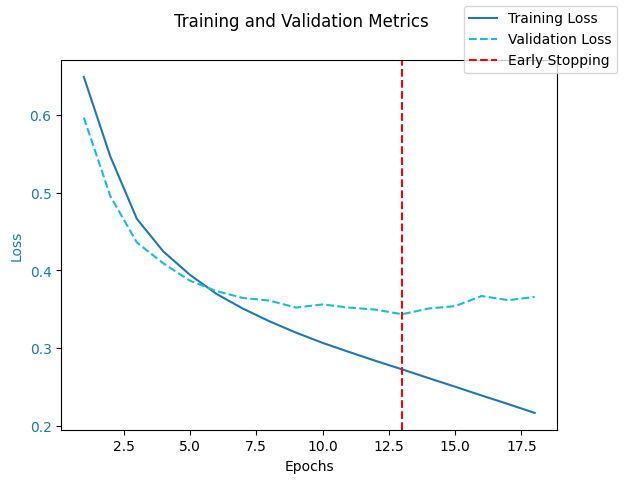


Training with seed 60
Early stopping at epoch 19.
Best Val F1: 0.8443.


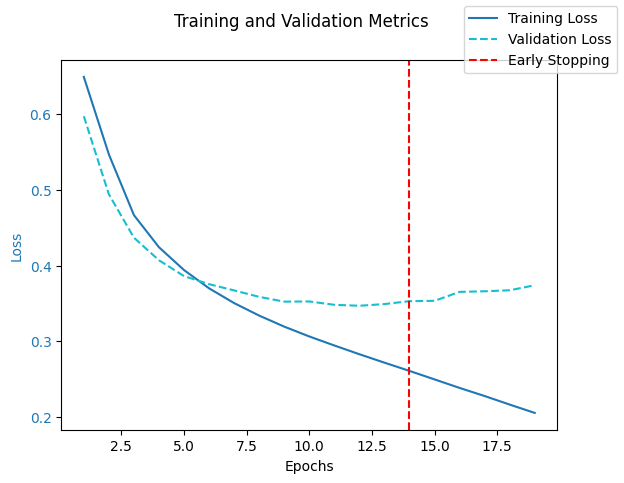

In [ ]:
models_one_layer_lstm = []
main_training_lstm(x_train, y_train, x_val, y_val, input_size, hidden_size, num_layers, output_size, models_one_layer_lstm, learning_rate, num_epochs, batch_size)

- BiRNN 1 layer evaluation

In [ ]:
evaluate_models(models_one_layer_rnn, x_test, y_test, batch_size=128, device=device)

Model 1:
  Test Accuracy: 0.8199
  Test F1 Score: 0.8135

Model 2:
  Test Accuracy: 0.8195
  Test F1 Score: 0.8147

Model 3:
  Test Accuracy: 0.8199
  Test F1 Score: 0.8140

Model 4:
  Test Accuracy: 0.8240
  Test F1 Score: 0.8194

Model 5:
  Test Accuracy: 0.8233
  Test F1 Score: 0.8186

Average Accuracy: 0.8213
Average F1 Score: 0.8160



- BiLSTM 1 layer evaluation

In [ ]:
evaluate_models(models_one_layer_lstm, x_test, y_test, batch_size=128, device=device)

Model 1:
  Test Accuracy: 0.8510
  Test F1 Score: 0.8499

Model 2:
  Test Accuracy: 0.8416
  Test F1 Score: 0.8412

Model 3:
  Test Accuracy: 0.8510
  Test F1 Score: 0.8500

Model 4:
  Test Accuracy: 0.8476
  Test F1 Score: 0.8467

Model 5:
  Test Accuracy: 0.8465
  Test F1 Score: 0.8459

Average Accuracy: 0.8475
Average F1 Score: 0.8467



- BiRNN 2 layers training


Training with seed 5
Layer                                    Parameters     
rnn.weight_ih_l0                         9600           
rnn.weight_hh_l0                         1024           
rnn.bias_ih_l0                           32             
rnn.bias_hh_l0                           32             
rnn.weight_ih_l0_reverse                 9600           
rnn.weight_hh_l0_reverse                 1024           
rnn.bias_ih_l0_reverse                   32             
rnn.bias_hh_l0_reverse                   32             
rnn.weight_ih_l1                         2048           
rnn.weight_hh_l1                         1024           
rnn.bias_ih_l1                           32             
rnn.bias_hh_l1                           32             
rnn.weight_ih_l1_reverse                 2048           
rnn.weight_hh_l1_reverse                 1024           
rnn.bias_ih_l1_reverse                   32             
rnn.bias_hh_l1_reverse                   32             
fc.weight

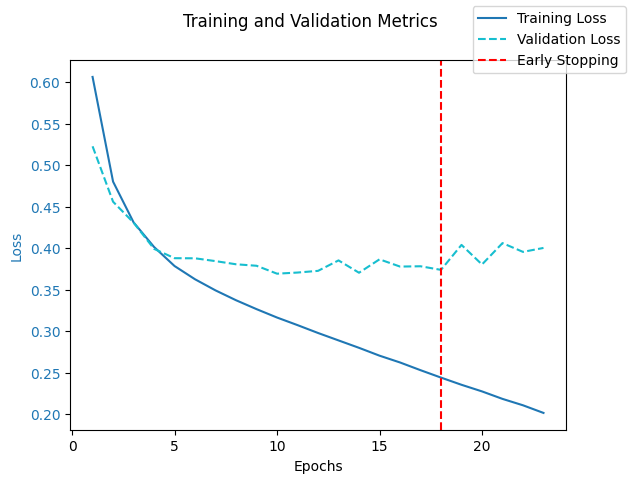


Training with seed 20
Early stopping at epoch 19.
Best Val F1: 0.8381.


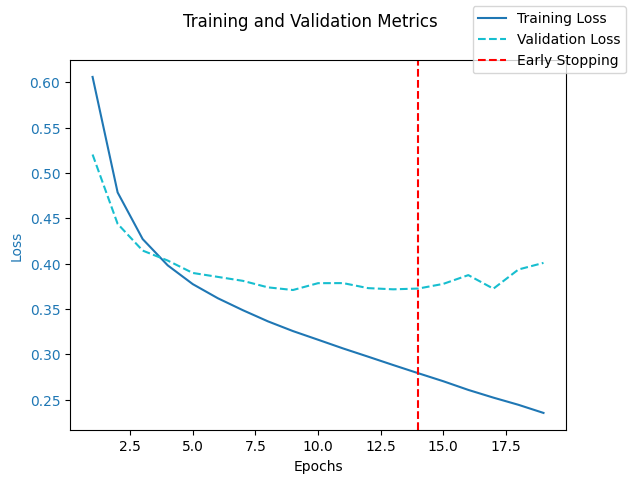


Training with seed 38
Early stopping at epoch 23.
Best Val F1: 0.8392.


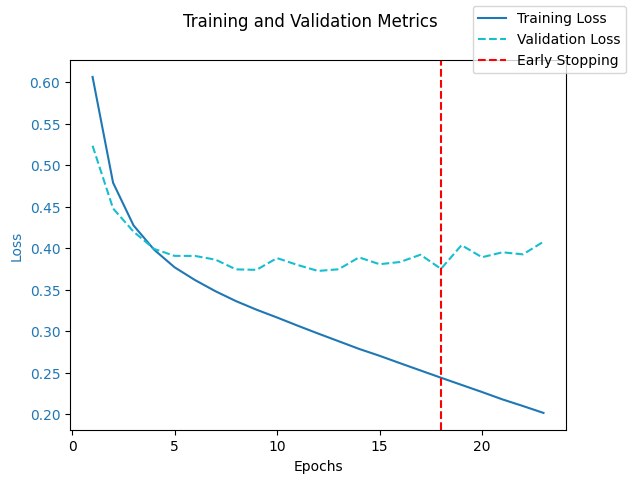


Training with seed 42
Early stopping at epoch 24.
Best Val F1: 0.8431.


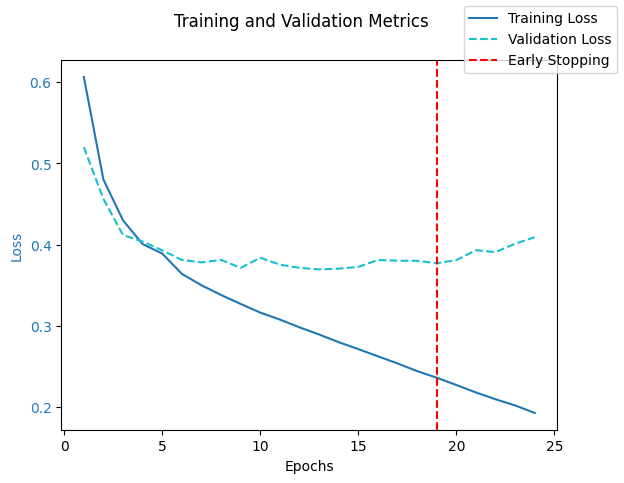


Training with seed 60
Early stopping at epoch 31.
Best Val F1: 0.8399.


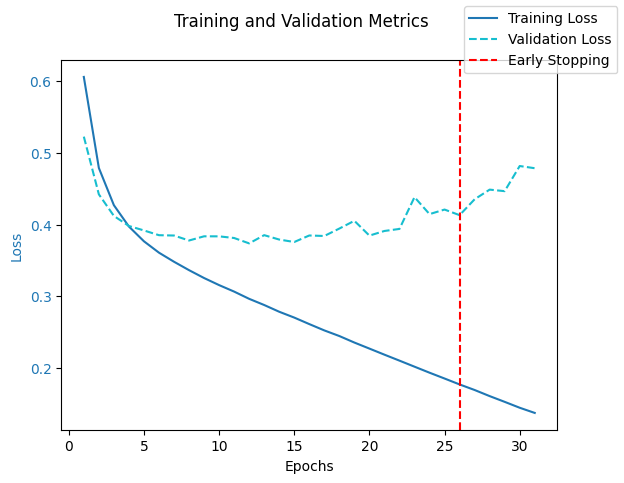

In [ ]:
num_layers = 2
models_two_layers_rnn = []
main_training_rnn(x_train, y_train, x_val, y_val, input_size, hidden_size, num_layers, output_size, models_two_layers_rnn, learning_rate, num_epochs, batch_size)

- BiLSTM 2 layers training


Training with seed 5
Layer                                    Parameters     
lstm.weight_ih_l0                        38400          
lstm.weight_hh_l0                        4096           
lstm.bias_ih_l0                          128            
lstm.bias_hh_l0                          128            
lstm.weight_ih_l0_reverse                38400          
lstm.weight_hh_l0_reverse                4096           
lstm.bias_ih_l0_reverse                  128            
lstm.bias_hh_l0_reverse                  128            
lstm.weight_ih_l1                        8192           
lstm.weight_hh_l1                        4096           
lstm.bias_ih_l1                          128            
lstm.bias_hh_l1                          128            
lstm.weight_ih_l1_reverse                8192           
lstm.weight_hh_l1_reverse                4096           
lstm.bias_ih_l1_reverse                  128            
lstm.bias_hh_l1_reverse                  128            
fc.weight

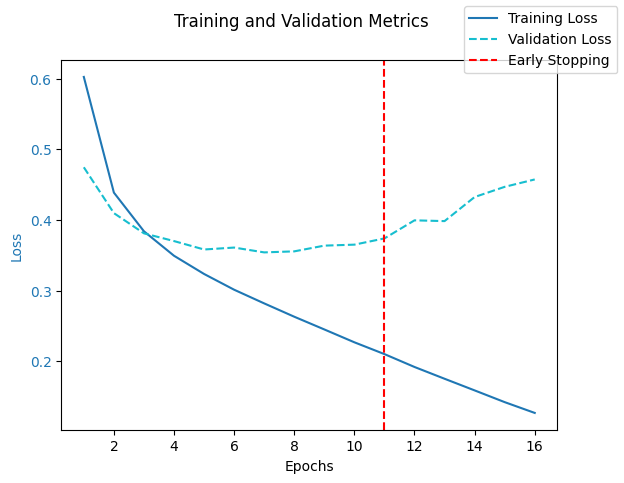


Training with seed 20
Early stopping at epoch 13.
Best Val F1: 0.8479.


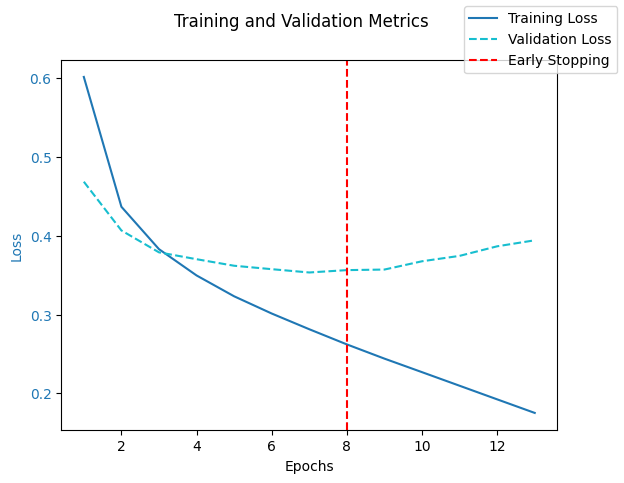


Training with seed 38
Early stopping at epoch 13.
Best Val F1: 0.8483.


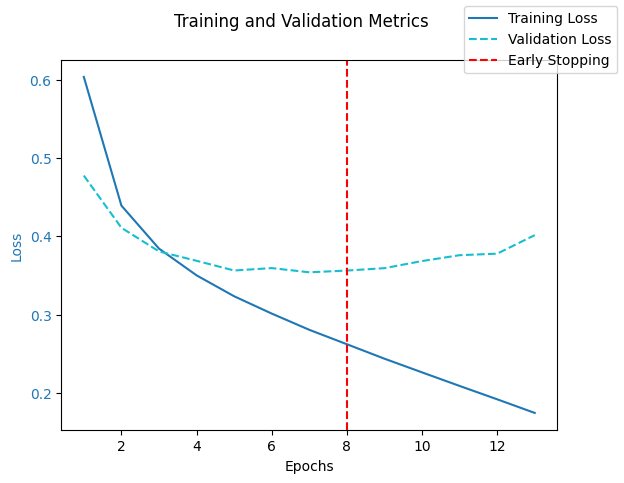


Training with seed 42
Early stopping at epoch 12.
Best Val F1: 0.8475.


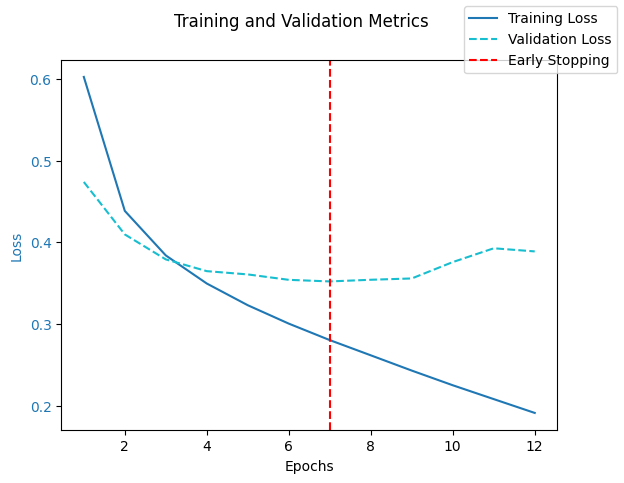


Training with seed 60
Early stopping at epoch 11.
Best Val F1: 0.8468.


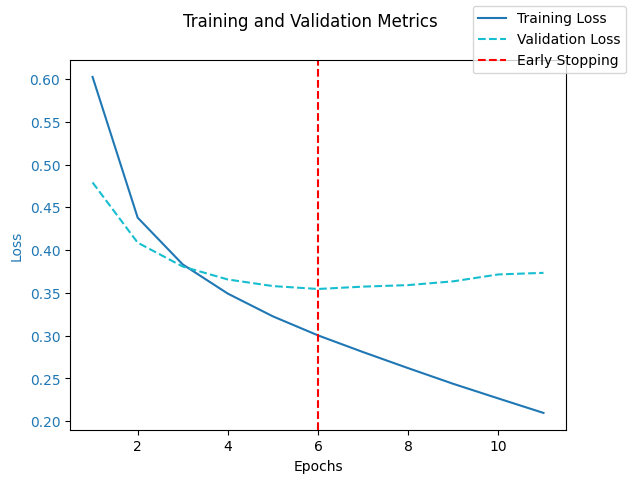

In [ ]:
models_two_layers_lstm = []
main_training_lstm(x_train, y_train, x_val, y_val, input_size, hidden_size, num_layers, output_size, models_two_layers_lstm, learning_rate, num_epochs, batch_size)

- BiRNN 2 layers evaluation

In [ ]:
evaluate_models(models_two_layers_rnn, x_test, y_test, batch_size=128, device=device)

Model 1:
  Test Accuracy: 0.8383
  Test F1 Score: 0.8370

Model 2:
  Test Accuracy: 0.8345
  Test F1 Score: 0.8339

Model 3:
  Test Accuracy: 0.8386
  Test F1 Score: 0.8379

Model 4:
  Test Accuracy: 0.8405
  Test F1 Score: 0.8394

Model 5:
  Test Accuracy: 0.8364
  Test F1 Score: 0.8351

Average Accuracy: 0.8377
Average F1 Score: 0.8367



- BiLSTM 2 layers evaluation

In [ ]:
evaluate_models(models_two_layers_lstm, x_test, y_test, batch_size=128, device=device)

Model 1:
  Test Accuracy: 0.8443
  Test F1 Score: 0.8431

Model 2:
  Test Accuracy: 0.8472
  Test F1 Score: 0.8455

Model 3:
  Test Accuracy: 0.8480
  Test F1 Score: 0.8468

Model 4:
  Test Accuracy: 0.8480
  Test F1 Score: 0.8468

Model 5:
  Test Accuracy: 0.8510
  Test F1 Score: 0.8495

Average Accuracy: 0.8477
Average F1 Score: 0.8463



# **CONCLUSIONS**

In conclusion, the results confirm that the Transformer model outperforms RNNs and LSTMs in terms of performance, thanks to its better ability to handle long-term dependencies. On the other hand, RNNs and LSTMs are lighter in terms of resources and can be used in scenarios with smaller datasets or hardware limitations. Although they are not as effective at managing long-term dependencies as Transformers, they still produced satisfactory results, proving to be a valid option for less complex tasks or environments with limited resources.